<a href="https://colab.research.google.com/github/lukekolbe/AL-in-CreditScoring/blob/main/result_processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep Runtime

In [5]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
#!pip freeze

In [ ]:
#!pip uninstall matplotlib -y

In [1]:
!pip install pingouin
!pip install scikit_posthocs
#!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 183 kB 8.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 34.4 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=2fc2c3ca45dee8bb27676ba774007429d913c981b95e3ada6ca0bd45d8f5bdbd
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=37a74befb96e22f06aae51a476a44df0489a5280256cd4e70ed7379fb5f49814
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting

In [2]:
############ LIBRARIES

import os
import time
import datetime
import random
import pickle
import re
import copy
import gc
import sys
import json

gc.enable()

import warnings
warnings.filterwarnings('ignore')

import pingouin as pg
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('default')
%matplotlib inline
import seaborn as sns

import scipy.stats
from collections import namedtuple
import scikit_posthocs as sp

In [3]:
############ RANDOMNESS
# seed function
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 30
seed_everything(seed)

In [6]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

# Helper Functions

In [71]:

'''
  This function is an enhanced version of the Friedman Test found in the popular scipy package.
  The added functionality computes z-values (pivotal quantities) that are needed to run the Holm-Test, i.e.
  pairwise comparisons of each model to the control model, with p-value adjustment.
  The formula for the z-statistic can be found in DEMSAR (2006).
'''

#FriedmanchisquareResult = namedtuple('FriedmanchisquareResult',
#                                     ('statistic', 'pvalue'))

def friedmanchisquare2(*args):
    """Compute the Friedman test for repeated measurements.
    The Friedman test tests the null hypothesis that repeated measurements of
    the same individuals have the same distribution.  It is often used
    to test for consistency among measurements obtained in different ways.
    For example, if two measurement techniques are used on the same set of
    individuals, the Friedman test can be used to determine if the two
    measurement techniques are consistent.
    Parameters
    ----------
    measurements1, measurements2, measurements3... : array_like
        Arrays of measurements.  All of the arrays must have the same number
        of elements.  At least 3 sets of measurements must be given.
    Returns
    -------
    statistic : float
        The test statistic, correcting for ties.
    pvalue : float
        The associated p-value assuming that the test statistic has a chi
        squared distribution.
    
    Notes
    -----
    Due to the assumption that the test statistic has a chi squared
    distribution, the p-value is only reliable for n > 10 and more than
    6 repeated measurements.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Friedman_test
    """

    k = len(args)
    if k < 3:
        raise ValueError('At least 3 sets of measurements must be given '
                         'for Friedman test, got {}.'.format(k))

    n = len(args[0])
    for i in range(1, k):
        if len(args[i]) != n:
            raise ValueError('Unequal N in friedmanchisquare.  Aborting.')

    # Rank data
    data = np.vstack(args).T
    data = data.astype(float)
    for i in range(len(data)):
        data[i] = scipy.stats.rankdata(data[i])

    # Handle ties
    ties = 0
    for d in data:
        replist, repnum = scipy.stats.find_repeats(np.array(d))
        for t in repnum:
            ties += t * (t*t - 1)
    c = 1 - ties / (k*(k*k - 1)*n)
    

    ssbn = np.sum(data.sum(axis=0)**2)
    chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c #test statistic
    pvalue = scipy.stats.distributions.chi2.sf(chisq, k - 1) #p-value

    ########## ADDED CUSTOM FUNCTIONALITY TO RUN HOLM TEST ##########
    #print('data from function', data)
    rankings_avg = [np.mean([case[j] for case in data]) for j in range(k)] #data is an array that includes 10 arrays (one for each dataset) of 12 values (one for each model).
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg] #test statistics (z-value) for each method (DEMSAR 2006)
    ##########

    return chisq, pvalue, data, rankings_avg, rankings_cmp

In [8]:
# ALTERNATIVE VERSION OF FRIEDMAN TEST
# APPLIES IMAN-DAVENPORT CORRECTION TO P-VALUES

def friedman_test(*args):

    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """

    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg] #see demsar (2006)

    chi2 = ((12*n)/float((k*(k+1))))*((sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4))) #(uncorrected) chi-square test statistic
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2)) #corrected test-statistic

    p_value = 1 - scipy.stats.f.cdf(iman_davenport, k-1, (k-1)*(n-1)) #iman-davenport corrected p-value
    
    ###########
    p_value_uncorrected = scipy.stats.distributions.chi2.sf(chi2, k - 1)
    ###########

    return iman_davenport,p_value, chi2, p_value_uncorrected, rankings, rankings_avg, rankings_cmp

In [9]:
def finner_test(pivots, control=None):
    """
        Performs a Finner post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method,  default the group with minimum ranking
            
        Returns
        ----------
        comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        adj_p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        H. Finner, On a monotonicity problem in step-down multiple test procedures, Journal of the American Statistical Association 88 (1993) 920–923.
    """
    
    k = len(pivots)
    values = list(pivots.values())
    keys = list(pivots.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons= map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max(1-(1-p_values[j])**((k-1)/float(j+1)) for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [10]:
import itertools as it

def holm_test(pivots, control=None):
    """
        Performs a Holm post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        adj_p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. S. Holm, A simple sequentially rejective multiple test procedure, Scandinavian Journal of Statistics 6 (1979) 65–70.
    """
    k = len(pivots.keys())
    values = list(pivots.values())
    keys = list(pivots.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max((k-(j+1))*p_values[j] for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [11]:
def bonferroni_dunn_test(pivots, control=None):
    """
        Performs a Bonferroni-Dunn post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        adj_p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. Dunn, Multiple comparisons among means, Journal of the American Statistical Association 56 (1961) 52–64.
    """
    k = len(pivots)
    values = list(pivots.values())
    keys = list(pivots.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min((k-1)*p_value,1) for p_value in p_values]
    
    return comparisons, z_values, p_values, adj_p_values

In [12]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def pairwise_plotter(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

# Load results as saved during computation

## SCORE METRICS

In [132]:
#load result files as specified, store in one large dictionary
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]
ratios_list = [0.1,0.2,0.3,0.4,0.5] #,0.2,0.3,0.4,0.5
cost_mat_list = [None] #only one cost setup was used, others are discarded due to unreliable results and computation issues
weights_list = ['wF', 'wT']
results_dict = {'wT': {}, 'wF': {}} #load results for parameter weights True/False separately

for w in weights_list:
  for d in dataset_list:
    results_dict[w][d] = {}
    for r in ratios_list:
      for c in cost_mat_list:
        if w == 'wT':
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-True_cost_matrix-{c}_do_thres-tuned"
        else:
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-False_cost_matrix-{c}_do_thres-tuned"
          
        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')

        infile = open(f'model_results/{d}/{filename}','rb')

        rname = f'r{r}'.replace('.', '')

        results_dict[w][d][rname] = pickle.load(infile)

        infile.close()
        #if fname not in configs_list:
        #  configs_list.append(fname)

#print(configs_list)

In [126]:
results_dict['wF']['gmsc']['r04']['score']['average']['pcc']

0     0.606595
1     0.627146
2     0.634152
3     0.634603
4     0.637322
5     0.642442
6     0.642401
7     0.647816
8     0.651361
9     0.645862
10    0.649972
Name: pcc, dtype: float64

In [133]:
# correct minor error with computation of PCC metric
# pcc was falsely computed as pcc=(tp+tn)/(FP+fn+tn+FP) >> fp added twice, instead of tp
# this fix corrects the score to (tn+tp)/(fn+fp+tn+tp) across all models, datasets and so on, using the stored values from the confusion matrix.

model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
rs=['r01','r02','r03','r04','r05']
kys=results_dict['wF']['gmsc']['r04']['score'].keys()
for w in weights_list:
  for d in dataset_list:
    for r in rs:
      for m in model_list:
        for k in kys:
          fn=results_dict[w][d][r][m][k]['fn']
          fp=results_dict[w][d][r][m][k]['fp']
          tn=results_dict[w][d][r][m][k]['tn']
          tp=results_dict[w][d][r][m][k]['tp']
          results_dict[w][d][r][m][k]['pcc'] = (tn+tp)/(fn+fp+tn+tp)


In [130]:
results_dict['wF']['gmsc']['r04']['score']['average']['pcc']

0     0.728640
1     0.743707
2     0.749273
3     0.749553
4     0.751467
5     0.755000
6     0.755460
7     0.759493
8     0.762147
9     0.758327
10    0.761187
Name: pcc, dtype: float64

## COST METRICS

In [134]:
#load result files as specified, store in one large dictionary
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]
cost_dict = {'wT': {}, 'wF': {}} #load results for parameter weights True/False separately
#configs_list = []

for w in weights_list:
  for d in dataset_list:
    cost_dict[w][d] = {}
    for r in ratios_list:
      for c in cost_mat_list:
        if w == 'wT':
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-True_cost_matrix-{c}_do_thres-tuned"
        else:
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-False_cost_matrix-{c}_do_thres-tuned"
          
        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')

        infile = open(f'model_cost/{d}/{filename}','rb')

        rname = f'r{r}'.replace('.', '')

        cost_dict[w][d][rname] = pickle.load(infile)

        infile.close()
        #if fname not in configs_list:
        #  configs_list.append(fname)

#print(configs_list)

In [135]:
cost_dict['wT']['bene2']['r05']['bmdr']['average']

generation  gen_internal_cost  gen_internal_cpl  total_internal_cost  \
0          0.0         340.200000          0.680400           340.200000   
1          1.0         285.533333          0.571067           625.733333   
2          2.0         271.466667          0.542933           897.200000   
3          3.0         285.333333          0.570667          1182.533333   
4          4.0         276.200000          0.552400          1458.733333   
5          5.0         275.000000          0.550000          1733.733333   
6          6.0         285.266667          0.570533          2019.000000   
7          7.0         282.333333          0.564667          2301.333333   
8          8.0         298.333333          0.596667          2599.666667   
9          9.0         292.866667          0.585733          2892.533333   
10        10.0         300.266667          0.600533          3192.800000   

    total_internal_cpl  model_internal_cost  model_internal_cpl  \
0             0.680400             0.000000                 NaN   
1             0.625733           285.533333            0.571067   
2             0.598133           557.000000            0.557000   
3             0.591267           842.333333            0.561556   
4             0.583493          1118.533333            0.559267   
5             0.577911          1393.533333            0.557413   
6             0.576857          1678.800000            0.559600   
7             0.575333          1961.133333            0.560324   
8             0.577704          2259.466667            0.564867   
9             0.578507          2552.333333            0.567185   
10            0.580509          2852.600000            0.570520   

    external_cost  external_cpl  
0      635.200000      0.441725  
1      611.133333      0.424988  
2      599.400000      0.416829  
3      587.266667      0.408391  
4      587.533333      0.408577  
5      578.133333      0.402040  
6      582.800000      0.405285  
7      578.600000      0.402364  
8      582.600000      0.405146  
9      582.333333      0.404961  
10     580.800000      0.403894

# Build table template to fill with aggregated results

In [136]:
# ALT: EVERY PARAMETER COMBINATION AS OWN CLASSIFER
#model_list = ['oracle','score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
performance_metrics = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','average_precision', 'precision', 'recall', 
                       'fpr', 'fnr', 'fn', 'fp', 'tp','tn', 'bad_ratio_accepts', 'bad_ratio_rejects', 'bad_ratio_AL_selects', 'bad_ratio_score_accepts'
]
cost_metrics = ['total_internal_cost','total_internal_cpl','external_cost','external_cpl']

# built list of column names
c_names = model_list

#column_names = ['score']
column_names = []

index_names = []

#################################
for m in model_list:
  for r in ["r01","r02","r03","r04","r05"]:
    for w in weights_list:
      column_names.append(f'{m}_{w}_{r}')
  #if m != 'score':
    #column_names.append(f'{m}_r05')
#################################

for d in dataset_list:
  for s in performance_metrics:
    for g in range(10):
      index_names.append(f'{d}_{s}_g{g+1}')
  for c in cost_metrics:
    for g in range(10):
      index_names.append(f'{d}_{c}_g{g+1}')

results_template = pd.DataFrame(columns=column_names, index=index_names)
#results_template

## Fill in results

In [137]:
# fill in values from results data
performance = copy.deepcopy(results_template)

for w in ['wT', 'wF']:
  for r in ["r01","r02","r03","r04","r05"]:
    for s in performance_metrics:
      for d in dataset_list:
        for g in range(10):
          for m in model_list:
            #print('RESULTS',w,r,s,d,g,m)
            performance.at[f'{d}_{s}_g{g+1}', f'{m}_{w}_{r}'] = results_dict[w][d][r][m]['average'][s][g+1]

    for c in cost_metrics:
      for d in dataset_list:
        for g in range(10):
          for m in model_list:
            #print('COST',w,r,c,d,g,m)

            performance.at[f'{d}_{c}_g{g+1}', f'{m}_{w}_{r}'] = cost_dict[w][d][r][m]['average'][c][g+1]


model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']

# add a total_cost metric
namelist=[]
for d in dataset_list:
  for g in range(10):
    namelist.append(f'{d}_total_cost_g{g+1}')
  
data = performance.loc[performance.index.str.contains('total_internal_cost')].values + performance.loc[performance.index.str.contains('external_cost')].values
total_cost = pd.DataFrame(data,index=namelist, columns = performance.columns)

performance = pd.concat((performance, total_cost))

# add a bad ratio of test prediction metric
# this was not stored during code runs, but can be computed ex post from the confusion matrix results that were stored: fn/(fn+fp+tn+tp)
namelist=[]
for d in dataset_list:
  for g in range(10):
    namelist.append(f'{d}_bad_ratio_test_g{g+1}')
  
data = performance.loc[performance.index.str.contains('_fn_')].values / (performance.loc[performance.index.str.contains('_fn_')].values + 
        performance.loc[performance.index.str.contains('_fp_')].values + 
        performance.loc[performance.index.str.contains('_tn_')].values +
        performance.loc[performance.index.str.contains('_tp_')].values)
bad_ratio_test = pd.DataFrame(data,index=namelist, columns = performance.columns)

performance = pd.concat((performance, bad_ratio_test))


In [ ]:
performance

score_wF_r01 score_wT_r01 score_wF_r02 score_wT_r02  \
australian_roc_auc_g1         0.898878     0.898878     0.897813     0.897813   
australian_roc_auc_g2         0.908488     0.908488     0.907168     0.907168   
australian_roc_auc_g3         0.919803     0.919803     0.915886     0.915886   
australian_roc_auc_g4         0.918804     0.918804     0.918293     0.918293   
australian_roc_auc_g5         0.916521     0.916521     0.916734     0.916734   
...                                ...          ...          ...          ...   
thomas_bad_ratio_test_g6      0.044898     0.044898     0.041633     0.041633   
thomas_bad_ratio_test_g7      0.043265     0.043265     0.039184     0.039184   
thomas_bad_ratio_test_g8      0.081633     0.081633     0.040816     0.040816   
thomas_bad_ratio_test_g9      0.082449     0.082449         0.04         0.04   
thomas_bad_ratio_test_g10     0.062857     0.062857     0.039184     0.039184   

                          score_wF_r03 score_wT_r03 score_wF_r04 score_wT_r04  \
australian_roc_auc_g1         0.898878     0.898878     0.897813     0.897813   
australian_roc_auc_g2         0.908488     0.908488     0.907168     0.907168   
australian_roc_auc_g3         0.919803     0.919803     0.915886     0.915886   
australian_roc_auc_g4         0.918804     0.918804     0.918293     0.918293   
australian_roc_auc_g5         0.916521     0.916521     0.916734     0.916734   
...                                ...          ...          ...          ...   
thomas_bad_ratio_test_g6      0.043265     0.043265     0.041633     0.041633   
thomas_bad_ratio_test_g7      0.043265     0.043265     0.039184     0.039184   
thomas_bad_ratio_test_g8      0.081633     0.081633     0.040816     0.040816   
thomas_bad_ratio_test_g9      0.082449     0.082449         0.04         0.04   
thomas_bad_ratio_test_g10     0.062857     0.062857     0.039184     0.039184   

                          score_wF_r05 score_wT_r05 random_wF_r01  \
australian_roc_auc_g1         0.898284     0.898284      0.897646   
australian_roc_auc_g2          0.91057      0.91057      0.907169   
australian_roc_auc_g3         0.918614     0.918614       0.90754   
australian_roc_auc_g4         0.919807     0.919807      0.906548   
australian_roc_auc_g5          0.92029      0.92029       0.91968   
...                                ...          ...           ...   
thomas_bad_ratio_test_g6      0.041633     0.041633      0.046531   
thomas_bad_ratio_test_g7      0.039184     0.039184      0.045714   
thomas_bad_ratio_test_g8      0.043265     0.043265      0.048163   
thomas_bad_ratio_test_g9      0.040816     0.040816      0.047347   
thomas_bad_ratio_test_g10     0.038367     0.038367      0.048163   

                          random_wT_r01 random_wF_r02 random_wT_r02  \
australian_roc_auc_g1          0.892962      0.897567      0.899172   
australian_roc_auc_g2           0.90112      0.912217      0.911362   
australian_roc_auc_g3          0.909587      0.914435      0.915364   
australian_roc_auc_g4           0.90921       0.91227       0.91924   
australian_roc_auc_g5          0.904992      0.907841      0.910978   
...                                 ...           ...           ...   
thomas_bad_ratio_test_g6       0.141224      0.044898      0.086531   
thomas_bad_ratio_test_g7       0.122449      0.048163      0.088163   
thomas_bad_ratio_test_g8       0.124898      0.053878      0.097143   
thomas_bad_ratio_test_g9       0.124082      0.086531      0.107755   
thomas_bad_ratio_test_g10      0.125714      0.066939      0.100408   

                          random_wF_r03 random_wT_r03 random_wF_r04  \
australian_roc_auc_g1          0.903978      0.907441      0.897465   
australian_roc_auc_g2          0.910097      0.911582       0.91031   
australian_roc_auc_g3          0.912578      0.906406      0.912651   
australian_roc_auc_g4          0.917499       0.90836      0.913503   
australian_roc_auc_g5          0.916901    

In [ ]:
performance.loc[performance.index.str.contains('bad_ratio_test')]

score_wF_r01 score_wT_r01 score_wF_r02  \
australian_bad_ratio_test_g1     0.076812     0.076812     0.076812   
australian_bad_ratio_test_g2     0.063768     0.063768     0.075362   
australian_bad_ratio_test_g3     0.053623     0.053623     0.063768   
australian_bad_ratio_test_g4     0.062319     0.062319     0.071014   
australian_bad_ratio_test_g5     0.076812     0.076812      0.07971   
...                                   ...          ...          ...   
thomas_bad_ratio_test_g6         0.044898     0.044898     0.041633   
thomas_bad_ratio_test_g7         0.043265     0.043265     0.039184   
thomas_bad_ratio_test_g8         0.081633     0.081633     0.040816   
thomas_bad_ratio_test_g9         0.082449     0.082449         0.04   
thomas_bad_ratio_test_g10        0.062857     0.062857     0.039184   

                             score_wT_r02 score_wF_r03 score_wT_r03  \
australian_bad_ratio_test_g1     0.076812     0.076812     0.076812   
australian_bad_ratio_test_g2     0.075362     0.063768     0.063768   
australian_bad_ratio_test_g3     0.063768     0.053623     0.053623   
australian_bad_ratio_test_g4     0.071014     0.062319     0.062319   
australian_bad_ratio_test_g5      0.07971     0.076812     0.076812   
...                                   ...          ...          ...   
thomas_bad_ratio_test_g6         0.041633     0.043265     0.043265   
thomas_bad_ratio_test_g7         0.039184     0.043265     0.043265   
thomas_bad_ratio_test_g8         0.040816     0.081633     0.081633   
thomas_bad_ratio_test_g9             0.04     0.082449     0.082449   
thomas_bad_ratio_test_g10        0.039184     0.062857     0.062857   

                             score_wF_r04 score_wT_r04 score_wF_r05  \
australian_bad_ratio_test_g1     0.076812     0.076812      0.07971   
australian_bad_ratio_test_g2     0.075362     0.075362     0.063768   
australian_bad_ratio_test_g3     0.063768     0.063768      0.05942   
australian_bad_ratio_test_g4     0.071014     0.071014     0.066667   
australian_bad_ratio_test_g5      0.07971      0.07971     0.085507   
...                                   ...          ...          ...   
thomas_bad_ratio_test_g6         0.041633     0.041633     0.041633   
thomas_bad_ratio_test_g7         0.039184     0.039184     0.039184   
thomas_bad_ratio_test_g8         0.040816     0.040816     0.043265   
thomas_bad_ratio_test_g9             0.04         0.04     0.040816   
thomas_bad_ratio_test_g10        0.039184     0.039184     0.038367   

                             score_wT_r05 random_wF_r01 random_wT_r01  \
australian_bad_ratio_test_g1      0.07971      0.089855      0.091304   
australian_bad_ratio_test_g2     0.063768      0.078261      0.088406   
australian_bad_ratio_test_g3      0.05942       0.07971      0.068116   
australian_bad_ratio_test_g4     0.066667      0.076812      0.075362   
australian_bad_ratio_test_g5     0.085507      0.071014      0.066667   
...                                   ...           ...           ...   
thomas_bad_ratio_test_g6         0.041633      0.046531      0.141224   
thomas_bad_ratio_test_g7         0.039184      0.045714      0.122449   
thomas_bad_ratio_test_g8         0.043265      0.048163      0.124898   
thomas_bad_ratio_test_g9         0.040816      0.047347      0.124082   
thomas_bad_ratio_test_g10        0.038367      0.048163      0.125714   

                             random_wF_r02 random_wT_r02 random_wF_r03  \
australian_bad_ratio_test_g1       0.07971      0.072464      0.081159   
australian_bad_ratio_test_g2      0.075362      0.075362      0.073913   
australian_bad_ratio_test_g3      0.071014       0.06087      0.078261   
australian_bad_ratio_test_g4      0.073913      0.065217      0.057971   
australian_bad_ratio_test_g5      0.086957      0.073913      0.065217   
...                                    ...           ...           ...   
thomas_bad_ratio_test_g6          0.044898      0.086531      0.039184   
t

# Performance and Ranks (AVERAGE SCORES)

## Prepare Data

In [275]:
"""
build row-wise ranks of the raw results, compute grand average ranks for all models, determine best-ranking version of each model
this best version is used for the subsequent performance comparison.
"""

#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'f1', 'average_precision', 'precision', 'recall', 'fpr', 'fnr', 'fn','fp','bad_ratio_score_accepts', 'bad_ratio_AL_selects','bad_ratio_accepts', 'bad_ratio_rejects','external_cpl', 'total_internal_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'bad_ratio_test','external_cpl', 'total_internal_cpl']
dataset_list = ["australian", "bene1_nobins","bene2","german","gmsc", "hmeq","lendingclub", "pakdd", "uk", 'thomas']

#############################################

#BUILD SUBSET OF RESULTS, based on metric and dataset choice
#then create a list of best-performing models, selecting each models' best-performing setup – either overall, or within a specified weight setup

# create list of row names (indices), depending on choice of datasets and metrics
index_names = ''
for i in dataset_list:
  for j in metrics_list:
    index_names += f'{i}_{j}|'
index_names = index_names[:len(index_names)-1] #remove last | symbol
print(index_names)


#store subset of performance and rank dataframes (selected lines only)
performance_sub = performance.loc[performance.index.str.contains(index_names)]
#performance_sub = performance.loc[performance.index.str.contains('g1|g2|g3|g4|g5')]
#performance_sub = performance.loc[performance.index.str.contains('g6|g7|g8|g9|g10')]

###############
# AUGMENT DATA SUBSET for running tests
# only keep one set of results for score model, it was run in every loop, but weights and AL-ratios have no effect on it, so all results are the same...
for m in model_list:
  if m == 'score':
    performance_sub['score'] = performance_sub.filter(regex=f'{m}_').mean(axis=1)
  #if m != 'score':
    #performance_sub.loc[:,f'{m}_r05'] = performance.filter(regex=f'{m}_.*_r05').mean(axis=1) 
    #no need to differentiate between wT and wF when r = 0.5, since the dynamic (inversely proportional) sample weights will all be 1
    #(no difference between score and AL-selections in terms of sample weights)

for m in model_list:
  for w in ['wT', 'wF']:
    if m == 'score':
      for r in ["r01","r02","r03","r04","r05"]:
        performance_sub = performance_sub.drop(f'{m}_{w}_{r}', axis=1)
    #if m != 'score':    
      #performance_sub = performance_sub.drop(f'{m}_{w}_r05', axis=1)

performance_sub = performance_sub.reindex(sorted(performance_sub.columns), axis=1)


###############
# BUILD RANKS after augmentation

performance_sub_ranks = performance_sub.rank(ascending=False, axis="columns")
##invert ranks for metrics where less is better
performance_sub_ranks.loc[~performance_sub_ranks.index.str.contains('roc_auc|h-measure|pcc|f1|average_precision|precision|recall|bad_ratio_rejects|balanced_accuracy|tn|tp')] = performance_sub.loc[~performance_sub.index.str.contains('roc_auc|h-measure|pcc|f1|average_precision|precision|recall|bad_ratio_rejects|balanced_accuracy|tn|tp')].rank(ascending=True, axis="columns")
#performance_sub_ranks.loc[performance_sub_ranks.index.str.contains('brier|cost|cpl|bad_ratio_accepts|fnr|fpr|fn|fr|bad_ratio_score_accepts|bad_ratio_AL_selects')] = performance_sub.loc[performance_sub.index.str.contains('brier|cost|cpl')].rank(ascending=True, axis="columns")
#performance_sub_ranks = performance_ranks.loc[performance.index.str.contains(index_names)]

## build various mean ranks with different criteria – best models are chosen based on these ranks
performance_sub_ranks.loc['mean_ranks']=performance_sub_ranks.loc[~performance_sub_ranks.index.str.contains('internal')].mean()
performance_sub_ranks.loc['cost_ranks']=performance_sub_ranks.loc[performance_sub_ranks.index.str.contains('external_cpl')].mean()


###############
# get best-performing models, determined by average rank over datasets
# three setups: overall best, best by either weight setup
# option to pick best models either by averaging scores except internal cost, or by just picking external cost

#rank_choice = 'mean_ranks'
rank_choice = 'cost_ranks'

best_performers = {}
namelist = ['score']
#namelist = []
for m in model_list:
  #print(m)
  if m != 'score':
    #print(performance_sub_ranks.filter(regex=f'{m}').loc[rank_choice])
    #print(performance_sub_ranks.filter(regex=f'{m}').loc[rank_choice].idxmin())
    namelist.append(performance_sub_ranks.filter(regex=f'{m}').loc[rank_choice].idxmin())
best_performers['overall'] = namelist

for w in ['wT', 'wF']:
  namelist = ['score']
  #namelist = []
  for m in model_list:
    #print(m)
    if m != 'score':
      #print(performance_sub_ranks.filter(regex=f'{m}_{w}').loc[rank_choice])
      #print(performance_sub_ranks.filter(regex=f'{m}_{w}').loc[rank_choice].idxmin())
      namelist.append(performance_sub_ranks.filter(regex=f'{m}_{w}').loc[rank_choice].idxmin())
  best_performers[w] = namelist

for i in best_performers.keys():
  print(best_performers[i])

performance_sub_ranks

australian_roc_auc|australian_brier|australian_h-measure|australian_pcc|australian_bad_ratio_test|australian_external_cpl|australian_total_internal_cpl|bene1_nobins_roc_auc|bene1_nobins_brier|bene1_nobins_h-measure|bene1_nobins_pcc|bene1_nobins_bad_ratio_test|bene1_nobins_external_cpl|bene1_nobins_total_internal_cpl|bene2_roc_auc|bene2_brier|bene2_h-measure|bene2_pcc|bene2_bad_ratio_test|bene2_external_cpl|bene2_total_internal_cpl|german_roc_auc|german_brier|german_h-measure|german_pcc|german_bad_ratio_test|german_external_cpl|german_total_internal_cpl|gmsc_roc_auc|gmsc_brier|gmsc_h-measure|gmsc_pcc|gmsc_bad_ratio_test|gmsc_external_cpl|gmsc_total_internal_cpl|hmeq_roc_auc|hmeq_brier|hmeq_h-measure|hmeq_pcc|hmeq_bad_ratio_test|hmeq_external_cpl|hmeq_total_internal_cpl|lendingclub_roc_auc|lendingclub_brier|lendingclub_h-measure|lendingclub_pcc|lendingclub_bad_ratio_test|lendingclub_external_cpl|lendingclub_total_internal_cpl|pakdd_roc_auc|pakdd_brier|pakdd_h-measure|pakdd_pcc|pakdd_bad_

bmdr_wF_r01  bmdr_wF_r02  bmdr_wF_r03  bmdr_wF_r04  \
bene2_roc_auc_g1              29.0000    45.000000        58.00        46.00   
bene2_roc_auc_g2              26.0000    19.000000        49.00        60.00   
bene2_roc_auc_g3              26.0000    30.000000        45.00        53.00   
bene2_roc_auc_g4              37.0000    29.000000        61.00        54.00   
bene2_roc_auc_g5              23.0000    18.000000        47.00        62.00   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g8       14.0000    15.000000        27.00        51.00   
pakdd_bad_ratio_test_g9       16.0000    15.000000        31.00        44.00   
pakdd_bad_ratio_test_g10      15.0000    16.000000        18.50        28.00   
mean_ranks                    56.2425    56.248333        54.56        47.84   
cost_ranks                    46.8200    47.605000        49.48        45.08   

                          bmdr_wF_r05  bmdr_wT_r01  bmdr_wT_r02  bmdr_wT_r03  \
bene2_roc_auc_g1            53.500000      106.000      51.0000       72.000   
bene2_roc_auc_g2            43.500000       96.000      41.0000       58.000   
bene2_roc_auc_g3            50.500000      104.000      74.0000       56.000   
bene2_roc_auc_g4            55.500000      108.000      92.0000       52.000   
bene2_roc_auc_g5            51.500000      104.000      59.0000       36.000   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g8     40.500000      107.000      81.0000       66.000   
pakdd_bad_ratio_test_g9     47.500000      106.000      86.0000       68.000   
pakdd_bad_ratio_test_g10    42.500000      103.000      71.0000       61.000   
mean_ranks                  48.646667       79.520      69.9325       56.060   
cost_ranks                  44.130000       91.545      77.8200       54.765   

                          bmdr_wT_r04  bmdr_wT_r05  cors_wF_r01  cors_wF_r02  \
bene2_roc_auc_g1            30.000000    53.500000      26.0000        28.00   
bene2_roc_auc_g2            47.000000    43.500000      34.0000        45.00   
bene2_roc_auc_g3            57.000000    50.500000      61.0000        54.00   
bene2_roc_auc_g4            59.000000    55.500000      57.0000        46.00   
bene2_roc_auc_g5            57.000000    51.500000      50.0000        30.00   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g8     62.000000    40.500000      18.0000        17.00   
pakdd_bad_ratio_test_g9     66.000000    47.500000      21.0000        25.00   
pakdd_bad_ratio_test_g10    39.000000    42.500000      17.0000        21.00   
mean_ranks                  47.128333    48.646667      58.3725        59.92   
cost_ranks                  43.635000    44.130000      46.9400        55.36   

                          cors_wF_r03  cors_wF_r04  cors_wF_r05  cors_wT_r01  \
bene2_roc_auc_g1              41.0000        61.00    39.500000      94.0000   
bene2_roc_auc_g2              51.0000        61.00    64.500000      81.0000   
bene2_roc_auc_g3              64.0000        63.00    58.500000      95.0000   
bene2_roc_auc_g4              58.0000        48.00    32.500000      88.0000   
bene2_roc_auc_g5              64.0000        44.00    41.500000      97.0000   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g8       29.0000        46.00    42.500000      98.0000   
pakdd_bad_ratio_test_g9       33.5000        60.00    56.500000      95.0000   
pakdd_bad_ratio_test_g10      23.0000        46.00    52.500000      97.0000   
mean_ranks                    56.8875        54.58    48.925833      80.3275   
cost_ranks                    58.2650        58.14    51.195000      91.4100   

                          cors_wT_r02  cors_wT_r03  cors_wT_r04  cors_wT_r05  \
bene2_roc_auc_g1            20.000000    11.000000       43.000    39.500000   
bene2_roc_auc_g2      

In [ ]:
performance_sub[best_performers['overall']]

score random_wT_r04 unc_wF_r01 qbc_wT_r04  \
australian_roc_auc_g1      0.898333      0.898186    0.89225   0.899371   
australian_roc_auc_g2      0.908376      0.911626   0.903766   0.910318   
australian_roc_auc_g3      0.917998      0.912189   0.913758   0.918813   
australian_roc_auc_g4      0.918800      0.910784   0.917443   0.917117   
australian_roc_auc_g5      0.917360      0.910475   0.916015   0.920136   
...                             ...           ...        ...        ...   
thomas_bad_ratio_test_g6   0.042612      0.084082   0.044082   0.058776   
thomas_bad_ratio_test_g7   0.040816      0.070204   0.043265   0.054694   
thomas_bad_ratio_test_g8   0.057633      0.066122   0.046531   0.062857   
thomas_bad_ratio_test_g9   0.057143      0.068571   0.046531   0.061224   
thomas_bad_ratio_test_g10  0.048490      0.065306   0.044082    0.05551   

                          dw_wF_r03 cors_wF_r01 density_wT_r04 eer_wF_r02  \
australian_roc_auc_g1      0.895057    0.897523       0.902017   0.901167   
australian_roc_auc_g2      0.908378    0.901987       0.907923   0.914387   
australian_roc_auc_g3      0.919155    0.920916       0.907771   0.921382   
australian_roc_auc_g4      0.918648    0.922093       0.909832   0.919455   
australian_roc_auc_g5      0.921369    0.923116       0.908638   0.917666   
...                             ...         ...            ...        ...   
thomas_bad_ratio_test_g6   0.051429    0.084082       0.054694   0.047347   
thomas_bad_ratio_test_g7   0.047347    0.084898       0.061224   0.053878   
thomas_bad_ratio_test_g8    0.08898    0.075918       0.061224   0.054694   
thomas_bad_ratio_test_g9    0.08898    0.080816       0.065306   0.053061   
thomas_bad_ratio_test_g10  0.077551    0.072653       0.067755   0.053878   

                          lal_wF_r02 quire_wT_r04 bmdr_wT_r04 spal_wF_r04  
australian_roc_auc_g1       0.896283      0.90257    0.899828    0.901419  
australian_roc_auc_g2       0.910309     0.907965    0.909992    0.908052  
australian_roc_auc_g3       0.916644     0.914176    0.913842    0.916979  
australian_roc_auc_g4       0.917323     0.914436    0.914264    0.911796  
australian_roc_auc_g5        0.92026     0.920651     0.91712    0.915412  
...                              ...          ...         ...         ...  
thomas_bad_ratio_test_g6    0.044898     0.052245    0.054694    0.049796  
thomas_bad_ratio_test_g7    0.045714     0.058776     0.04898    0.051429  
thomas_bad_ratio_test_g8    0.042449      0.06449    0.053061    0.057959  
thomas_bad_ratio_test_g9    0.045714     0.084898    0.073469    0.056327  
thomas_bad_ratio_test_g10   0.045714     0.079184    0.103673    0.056327  

[700 rows x 12 columns]

In [ ]:
performance_sub_ranks.filter(regex='bmdr_wT')

In [ ]:
performance_sub_ranks.loc[performance_sub_ranks.index.str.contains('bad_ratio_test')]

bmdr_wF_r01  bmdr_wF_r02  bmdr_wF_r03  bmdr_wF_r04  \
bene2_bad_ratio_test_g1          93.0         99.0        101.0         90.0   
bene2_bad_ratio_test_g2          95.0        100.0         98.0         69.5   
bene2_bad_ratio_test_g3          97.5        102.0        103.0         81.0   
bene2_bad_ratio_test_g4         106.0         97.0        100.5         78.0   
bene2_bad_ratio_test_g5         105.0         89.5        108.0         73.0   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g6          16.0         17.0         19.0         28.0   
pakdd_bad_ratio_test_g7          19.0          9.0         23.0         33.0   
pakdd_bad_ratio_test_g8          14.0         15.0         27.0         51.0   
pakdd_bad_ratio_test_g9          16.0         15.0         31.0         44.0   
pakdd_bad_ratio_test_g10         15.0         16.0         18.5         28.0   

                          bmdr_wF_r05  bmdr_wT_r01  bmdr_wT_r02  bmdr_wT_r03  \
bene2_bad_ratio_test_g1          77.5        110.5        110.5        105.0   
bene2_bad_ratio_test_g2          53.0        111.0        107.0        104.0   
bene2_bad_ratio_test_g3          56.5        110.0        108.0        104.5   
bene2_bad_ratio_test_g4          68.5        109.0        108.0        100.5   
bene2_bad_ratio_test_g5          56.5        109.0        102.5         94.0   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g6          31.0         74.0         70.0         63.0   
pakdd_bad_ratio_test_g7          38.5        104.0         73.0         63.0   
pakdd_bad_ratio_test_g8          40.5        107.0         81.0         66.0   
pakdd_bad_ratio_test_g9          47.5        106.0         86.0         68.0   
pakdd_bad_ratio_test_g10         42.5        103.0         71.0         61.0   

                          bmdr_wT_r04  bmdr_wT_r05  cors_wF_r01  cors_wF_r02  \
bene2_bad_ratio_test_g1          97.0         77.5         95.5         85.0   
bene2_bad_ratio_test_g2          86.0         53.0         99.0         91.0   
bene2_bad_ratio_test_g3          93.5         56.5         89.0         83.5   
bene2_bad_ratio_test_g4          93.0         68.5         91.5         67.0   
bene2_bad_ratio_test_g5          94.0         56.5         83.0         65.0   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g6          49.0         31.0         26.0         29.0   
pakdd_bad_ratio_test_g7          52.0         38.5         28.0         36.0   
pakdd_bad_ratio_test_g8          62.0         40.5         18.0         17.0   
pakdd_bad_ratio_test_g9          66.0         47.5         21.0         25.0   
pakdd_bad_ratio_test_g10         39.0         42.5         17.0         21.0   

                          cors_wF_r03  cors_wF_r04  cors_wF_r05  cors_wT_r01  \
bene2_bad_ratio_test_g1          77.5         81.0         21.0        109.0   
bene2_bad_ratio_test_g2          71.5         75.5         37.5        102.0   
bene2_bad_ratio_test_g3          76.0         63.0         20.5         96.0   
bene2_bad_ratio_test_g4          57.5         57.5         38.0         90.0   
bene2_bad_ratio_test_g5          60.0         47.0         19.5         75.0   
...                               ...          ...          ...          ...   
pakdd_bad_ratio_test_g6          45.0         57.0         54.5        102.0   
pakdd_bad_ratio_test_g7          43.0         59.0         53.5         97.0   
pakdd_bad_ratio_test_g8          29.0         46.0         42.5         98.0   
pakdd_bad_ratio_test_g9          33.5         60.0         56.5         95.0   
pakdd_bad_ratio_test_g10         23.0         46.0         52.5         97.0   

                          cors_wT_r02  cors_wT_r03  cors_wT_r04  cors_wT_r05  \
bene2_bad_ratio_test_g1          69.5         45.0         74.5         21.0   
bene2_bad_ratio_test_g

## Run Friedman and Post-Hoc tests for BEST PERFORMERS ONLY

In [141]:
#############################################
#RUN TESTS

friedman_results2 = {}
#nemenyi_results = {}
#conover_results = {}
#holm_results = {}
finner_results = {}
#quade_scores = {}
rankings_dict = {}
pval_dict = {}
test_results = {}

friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

for w in ['overall','wT', 'wF']: #,'wT', 'wF'
  print('\n\n\n------------------------\nSETUP:', w)
  print('best performing models:', best_performers[w])
  
  #nemenyi_results[w] = {}
  #conover_results[w] = {}
  #holm_results[w] = {}
  finner_results[w] = {}

  rankings = pd.DataFrame(columns = best_performers[w], index=metrics_list)
  pvals = pd.DataFrame(columns = best_performers[w], index=metrics_list)
  columns = best_performers[w]

  for s in metrics_list:
    metric_values = []

    for d in dataset_list:
      row_values = []

      for m in best_performers[w]:
        row_values.append(performance_sub[f'{m}'].loc[performance_sub.index.str.contains(f'{d}_{s}')].mean()) #mean over 10 generations
      
      metric_values.append(row_values)

    #invert sign of measurements for metrics where more is better
    #this is done because the friedman test uses the rankdata function, which assigns ranks from lowest to highest (low score = low rank)
    #if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl', 'total_cost', 'fnr','fpr','fn','fp','bad_ratio_accepts', 'bad_ratio_AL_selects']:
    if s in ['roc_auc','h-measure','pcc','f1','average_precision','precision','recall','bad_ratio_rejects','balanced_accuracy','tn','tp']:
      metric_values = np.array(metric_values) * -1
    
    print('\n\n------------------------\nMETRIC', s)
    print(pd.DataFrame(metric_values, columns = columns))

    statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values)) #this test applies the Iman-Davenport correction to
    #statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

    print(columns)
    print("average_ranks", ranking_avg)
    print("pivot", rank_cmp)

    temp = {'statistic':statistic, 'pvalue':pvalue}
    friedman_statistics.loc[f'{s}'] = temp
    rankings.loc[f'{s}'] = ranking_avg
    

    # POST HOC TEST HOLM
    pivot_scores = {key: rank_cmp[i] for i, key in enumerate(columns)} 
    print(pivot_scores)
    #print(pd.DataFrame(np.transpose(pivot_scores), columns = columns))
    
    #get the name of the best-ranking model to use as control
    ## REDUNDAND FEATURE; post-hoc tests automatically compare against lowest-scoring models when no control classifier is given...
    min_idx = pd.DataFrame(np.transpose(list(pivot_scores.values())), index = pivot_scores.keys()).iloc[:,0].idxmin() 
    
    '''comparisons, z_values, p_values, adj_p_values = holm_test(pivot_scores, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    #print(holm_scores)
    holm_results[w][s] = copy.deepcopy(holm_scores)'''

    #comparisons, z_values, p_values, adj_p_values, keys = finner_test(pivot_scores, control=columns[min_rank])
    comparisons, z_values, p_values, adj_p_values = finner_test(pivot_scores, control = min_idx)
    adj_p_values = np.asarray(adj_p_values)
    finner_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons, )
    print(p_values)
    print(adj_p_values)
    print(finner_scores)
    finner_results[w][s] = copy.deepcopy(finner_scores)

    for m in best_performers[w]:
      try:
        pvals.at[s,m] = np.round(finner_scores.loc[finner_scores.index.str.contains(f'vs {m}')]['p'].values, 3)
      except KeyError:
        pvals.at[s,m] = np.nan


    #nemenyi_results[w][s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
    #conover_results[w][s] = generate_scores(sp.posthoc_conover_friedman, {'p_adjust':'holm-sidak'}, metric_values, columns)
    #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)

  print(f'Friedman results\n',friedman_statistics,'\n\n')
  friedman_results2[w] = copy.deepcopy(friedman_statistics)
  pvals = pvals.T.add_suffix('_p-values')
  pvals.loc['Friedman'] = np.round(friedman_statistics['pvalue'].to_numpy().flatten().astype(float),3)
  pval_dict[w] = copy.deepcopy(pvals)

  rankings = rankings.T.add_suffix('_avg-rank')
  rankings.loc['Friedman'] = np.round(friedman_statistics['statistic'].to_numpy().flatten().astype(float),3)
  rankings['AvgRank'] = np.round(rankings.mean(axis=1),2)
  rankings['AvgRank'].loc['Friedman'] = np.nan
  rankings['HighScore'] = rankings['AvgRank'].rank()
  rankings_dict[w] = copy.deepcopy(rankings)


  combined_results = pd.concat((rankings, pvals), axis=1)
  combined_results = combined_results.reindex(sorted(combined_results.columns), axis=1)
  combined_results = combined_results.iloc[:,[12,13,8,9,4,5,10,11,2,3,6,7,14,15,0,1]].sort_values('HighScore') #custom order
  combined_results["temp"] = range(1,len(combined_results)+1)
  combined_results.loc[combined_results.index=='score', 'temp'] = 0
  combined_results = combined_results.sort_values("temp").drop('temp', axis=1)

  test_results[w] = combined_results







------------------------
SETUP: overall
best performing models: ['score', 'random_wT_r04', 'unc_wF_r01', 'qbc_wT_r04', 'dw_wF_r03', 'cors_wF_r01', 'density_wT_r04', 'eer_wF_r02', 'lal_wF_r02', 'quire_wT_r04', 'bmdr_wT_r04', 'spal_wF_r04']


------------------------
METRIC roc_auc
      score  random_wT_r04  unc_wF_r01  qbc_wT_r04  dw_wF_r03  cors_wF_r01  \
0 -0.918350      -0.915087   -0.916759   -0.920703  -0.919958    -0.916236   
1 -0.748293      -0.753867   -0.747846   -0.745927  -0.743562    -0.750068   
2 -0.778209      -0.777812   -0.776355   -0.779185  -0.777597    -0.777840   
3 -0.773833      -0.776912   -0.777436   -0.777290  -0.779121    -0.774126   
4 -0.839645      -0.843481   -0.841919   -0.843312  -0.843139    -0.842159   
5 -0.780813      -0.783517   -0.780313   -0.784620  -0.782407    -0.778114   
6 -0.620482      -0.625864   -0.625332   -0.627058  -0.622621    -0.620470   
7 -0.594101      -0.590028   -0.591857   -0.594965  -0.596153    -0.594124   
8 -0.711233   

In [151]:
#print results table in presentable fashion
test_results['overall'].astype(str).replace(to_replace={'\.]': '.0)','\[0': '(', '\]': ')', '\[': '( / ',}, regex=True)

roc_auc_avg-rank roc_auc_p-values h-measure_avg-rank  \
score                       7.6           (.068)                7.3   
qbc_wT_r04                  3.5            ( / )                3.4   
random_wT_r04               5.4           (.283)                4.7   
quire_wT_r04                5.4           (.283)                5.5   
bmdr_wT_r04                 6.5           (.085)                6.3   
density_wT_r04              6.6           (.084)                5.4   
dw_wF_r03                   7.2           (.068)                6.9   
eer_wF_r02                  7.8           (.068)                7.2   
unc_wF_r01                  7.5           (.068)                8.7   
lal_wF_r02                  7.2           (.068)                7.6   
spal_wF_r04                 5.4           (.283)                6.7   
cors_wF_r01                 7.9           (.068)                8.3   
Friedman                  1.419            0.176              1.974   

               h-measure_p-values brier_avg-rank brier_p-values pcc_avg-rank  \
score                      (.042)           10.5           (.0)          7.9   
qbc_wT_r04                  ( / )            2.6          ( / )          4.2   
random_wT_r04               (.42)            4.7         (.193)          4.2   
quire_wT_r04                (.23)            5.9         (.073)          6.9   
bmdr_wT_r04                (.098)            5.5         (.098)          3.2   
density_wT_r04             (.234)            5.5         (.098)          5.4   
dw_wF_r03                  (.054)            4.8         (.188)          7.0   
eer_wF_r02                 (.042)            5.9         (.073)          7.2   
unc_wF_r01                 (.011)            7.9         (.004)          7.3   
lal_wF_r02                 (.033)            7.6         (.005)          8.8   
spal_wF_r04                (.063)            7.1         (.012)          8.8   
cors_wF_r01                (.013)           10.0           (.0)          7.1   
Friedman                    0.039          5.766            0.0        3.155   

               pcc_p-values bad_ratio_test_avg-rank bad_ratio_test_p-values  \
score                (.013)                     5.8                  (.413)   
qbc_wT_r04           (.569)                     7.0                  (.211)   
random_wT_r04        (.569)                     8.4                  (.035)   
quire_wT_r04          (.03)                    4.85                  (.721)   
bmdr_wT_r04           ( / )                    8.95                  (.035)   
density_wT_r04       (.207)                     8.6                  (.035)   
dw_wF_r03             (.03)                     6.7                   (.22)   
eer_wF_r02            (.03)                     5.5                  (.486)   
unc_wF_r01            (.03)                     6.7                   (.22)   
lal_wF_r02           (.006)                     4.5                  (.852)   
spal_wF_r04          (.006)                     4.2                   ( / )   
cors_wF_r01           (.03)                     6.8                   (.22)   
Friedman              0.001                   2.186                   0.021   

               external_cpl_avg-rank external_cpl_p-values  \
score                            7.2                (.663)   
qbc_wT_r04                       4.6                 ( / )   
random_wT_r04                    5.2                 (.71)   
quire_wT_r04                     5.8                (.663)   
bmdr_wT_r04                      6.9                (.663)   
density_wT_r04                   6.7                (.663)   
dw_wF_r03                        6.9                (.663)   
eer_wF_r02                       7.3                (.663)   
unc_wF_r01                       6.4                (.663)   
lal_wF_r02                       6.5                (.663)   
spal_wF_r04                      7.2                (.663)   
cors_wF_r01                      7.3            

In [ ]:
friedman_results2['overall']

statistic    pvalue
roc_auc             14.984615  0.183202
brier               42.953846  0.000011
h-measure           19.784615  0.048383
pcc                 29.815385  0.001694
bad_ratio_test      21.503673  0.028513
external_cpl         6.476923  0.839726
total_internal_cpl  54.938462       0.0

In [ ]:
friedman = np.round(friedman_results2['overall'].to_numpy().flatten().astype(float),4)
friedman

In [ ]:
friedman_results2['overall']

In [ ]:
finner_results['overall']

In [ ]:
holm_results['overall']

In [ ]:
nemenyi_results['overall']['brier']

In [ ]:
'''for k1 in nemenyi_results.keys():
  for k2 in nemenyi_results[k1].keys():
    pairwise_plotter(nemenyi_results[k1][k2])'''

#pairwise_plotter(nemenyi_results['overall']['total_internal_cpl'])
pairwise_plotter(conover_results['overall']['roc_auc'])

In [ ]:
sp.sign_plot(nemenyi_results['overall']['brier'])

## Run Friedman Tests for 2x60 models (average SCORES)

In [ ]:
"""
  Runs test comparing ALL models for each weight setup
"""

'''
#model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc','balanced_accuracy', 'f1', 'total_internal_cpl','external_cpl']  #'brier', 'h-measure', 'pcc',
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "pakdd", "australian", "german"] #,"thomas", 
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "hmeq", "australian", "german"]
#dataset_list = ["lendingclub", "thomas", "pakdd"]


friedman_results = {'wT':{}, 'wF':{}}
nemenyi_scores = {}
quade_scores = {}

for w in ['wT', 'wF']:
  friedman_results[w] = {}
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

  for s in metrics_list:
    metric_values = []

    for d in dataset_list:
      row_values = []
      columns = []

      for m in model_list:
        row_values.extend(performance.filter(regex=f'{m}_{w}').loc[performance.index.str.contains(f'{d}_{s}')].mean().tolist())
        columns.extend(list(performance.filter(regex=f'{m}_{w}').columns))
      
      metric_values.append(row_values)

    #invert sign of measurements for metrics where more is better – needed because friedmanchisquare() uses scipy.stats.rankdata(), which ranks in ascending fashion (low value -> low rank)
    if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
      metric_values = np.array(metric_values) * -1

    print('\n\n\n------------------------\nMETRIC', s)

    #statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values))
    statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

    print('\n-------------------------------\nscipy Friedman MODDED\n-------------------------------\n')
    for pr in [statistic, pvalue, ranking_avg, rank_cmp]: #, ranking,ranking_avg, rank_cmp]:
      print(pr)

    temp = {'statistic':statistic, 'pvalue':pvalue}
    friedman_statistics.loc[f'{s}'] = temp



    # POST HOC TEST HOLM
    ranks = {key: rank_cmp[i] for i, key in enumerate(columns)} 
    min_rank = pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0].argmin()
    
    comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    print(holm_scores)    


    comparisons, z_values, p_values, adj_p_values = finner_test(pivot_scores, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    finner_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    print(finner_scores)
    #finner_results[w][s] = copy.deepcopy(finner_scores)


    #nemenyi_scores[s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
    #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)


  print(np.shape(metric_values))
  print(f'Friedman results for {w}\n',friedman_statistics,'\n\n')
  friedman_results[w][r] = friedman_statistics'''

'''for key in nemenyi_scores.keys():
  pairwise_plotter(nemenyi_scores[key])'''


In [ ]:
columns = []
columns.append(performance.filter(regex='bmdr_wT').columns)
type(columns)

list

In [ ]:
 performance.filter(regex=f'{w}_{r}').columns

Index(['bmdr_wF_r05', 'cors_wF_r05', 'density_wF_r05', 'dw_wF_r05',
       'eer_wF_r05', 'lal_wF_r05', 'qbc_wF_r05', 'quire_wF_r05',
       'random_wF_r05', 'score_wF_r05', 'spal_wF_r05', 'unc_wF_r05'],
      dtype='object')

In [ ]:
pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys())

0
score_wF_r05    2.668498
random_wF_r05   3.780372
unc_wF_r05      3.520934
qbc_wF_r05      3.261497
dw_wF_r05       3.854496
cors_wF_r05     3.632122
density_wF_r05  3.039122
eer_wF_r05      3.150310
lal_wF_r05      4.521621
quire_wF_r05    2.446123
bmdr_wF_r05     2.816747
spal_wF_r05     3.780372

In [ ]:
ranks

{'bmdr_wF_r05': 2.816747403312185,
 'cors_wF_r05': 3.632121651639396,
 'density_wF_r05': 3.0391221983105146,
 'dw_wF_r05': 3.8544964466377265,
 'eer_wF_r05': 3.15030959580968,
 'lal_wF_r05': 4.521620831632717,
 'qbc_wF_r05': 3.261496993308845,
 'quire_wF_r05': 2.446122744981634,
 'random_wF_r05': 3.780371514971616,
 'score_wF_r05': 2.6684975399799646,
 'spal_wF_r05': 3.780371514971616,
 'unc_wF_r05': 3.5209342541402306}

In [ ]:
friedman_results

## run separate tests for each combination of weights and ratio

In [ ]:
'''#Friedman Test with post-hoc test
#model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc','balanced_accuracy', 'f1', 'total_internal_cpl','external_cpl']  #'brier', 'h-measure', 'pcc',
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "pakdd"] #"australian", "german", "thomas", 
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "hmeq", "australian", "german"]
#dataset_list = ["lendingclub", "thomas", "pakdd"]


friedman_results = {'wT':{}, 'wF':{}}
nemenyi_scores = {}
quade_scores = {}

average_ratios = False #this feature does not work correctly, if this is enabled it is unnecessary to loop over ratios. 

for w in ['wT', 'wF']:
  friedman_results[w] = {}
  
  for r in ["r01","r02","r03","r04","r05"]:
    friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

    for s in metrics_list:
      metric_values = []

      for d in dataset_list:
        row_values = []
        if average_ratios:
          columns = model_list
        else:
          columns = []

        for m in model_list:
          if average_ratios:
            row_values.append(performance.filter(regex=f'{m}_{w}').loc[performance.index.str.contains(f'{d}_{s}')].mean().mean())
          else:
            row_values.extend(performance.filter(regex=f'{m}_{w}_{r}').loc[performance.index.str.contains(f'{d}_{s}')].mean().tolist())
            columns.append(f'{m}_{w}_{r}')
        
        metric_values.append(row_values)

      #invert sign of measurements for metrics where more is better – needed because friedmanchisquare() uses scipy.stats.rankdata(), which ranks in ascending fashion (low value -> low rank)
      if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
        metric_values = np.array(metric_values) * -1

      print('\n\n\n------------------------\nMETRIC', s)

      #statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values))
      statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

      print('\n-------------------------------\nscipy Friedman MODDED\n-------------------------------\n')
      for pr in [statistic, pvalue, ranking_avg, rank_cmp]: #, ranking,ranking_avg, rank_cmp]:
        print(pr)

      print('\n-------------------------------\nCustom STAC\n-------------------------------\n')
      print(friedman_test(*np.transpose(metric_values)))

      temp = {'statistic':statistic, 'pvalue':pvalue}
      friedman_statistics.loc[f'{s}'] = temp



      # POST HOC TEST HOLM
      ranks = {key: rank_cmp[i] for i, key in enumerate(columns)} 
      print('ranking_avg', ranking_avg)
      print(pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0])
      min_rank = pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0].argmin()
      
      comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control=columns[min_rank])
      adj_p_values = np.asarray(adj_p_values)
      holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
      print(holm_scores)    

      #nemenyi_scores[s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
      #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)


    print(np.shape(metric_values))
    print(f'Friedman results for {w}\n',friedman_statistics,'\n\n')
    friedman_results[w][r] = friedman_statistics'''

'''for key in nemenyi_scores.keys():
  pairwise_plotter(nemenyi_scores[key])'''


# PLOTS

In [20]:
import matplotlib as mpl
#from colorspacious import cspace_converter


import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('default')
%matplotlib inline
import seaborn as sns
from itertools import cycle


In [21]:
metrics_short = ['AUC','BS','HM','PCC','BR','ECPL','ICPL']
position_list = ['bottom right','upper right','upper left','upper left','upper left','bottom left','bottom left']
metric_tuples = list(zip(metrics_list, metrics_short, position_list))
print(metric_tuples)

[('roc_auc', 'AUC', 'bottom right'), ('brier', 'BS', 'upper right'), ('h-measure', 'HM', 'upper left'), ('pcc', 'PCC', 'upper left'), ('bad_ratio_test', 'BR', 'upper left'), ('external_cpl', 'ECPL', 'bottom left'), ('total_internal_cpl', 'ICPL', 'bottom left')]


## performance per metric & datasets over periods

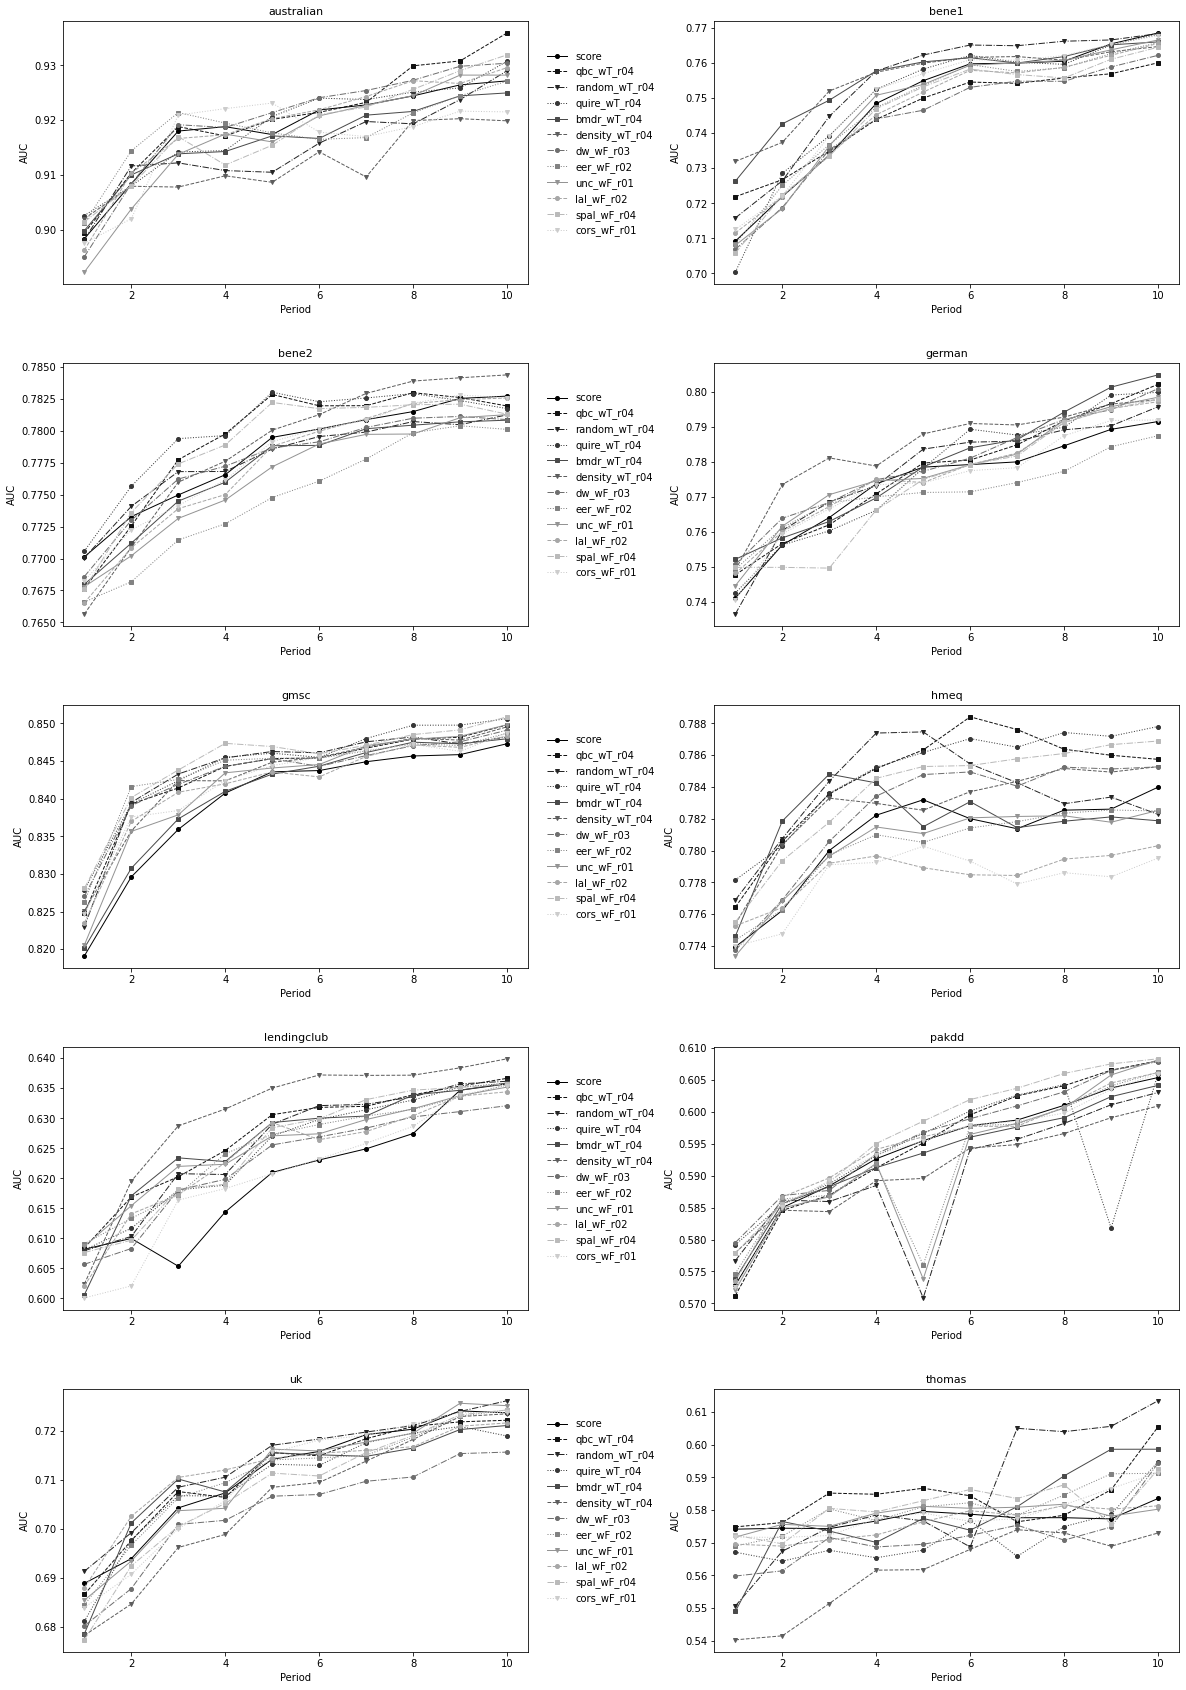

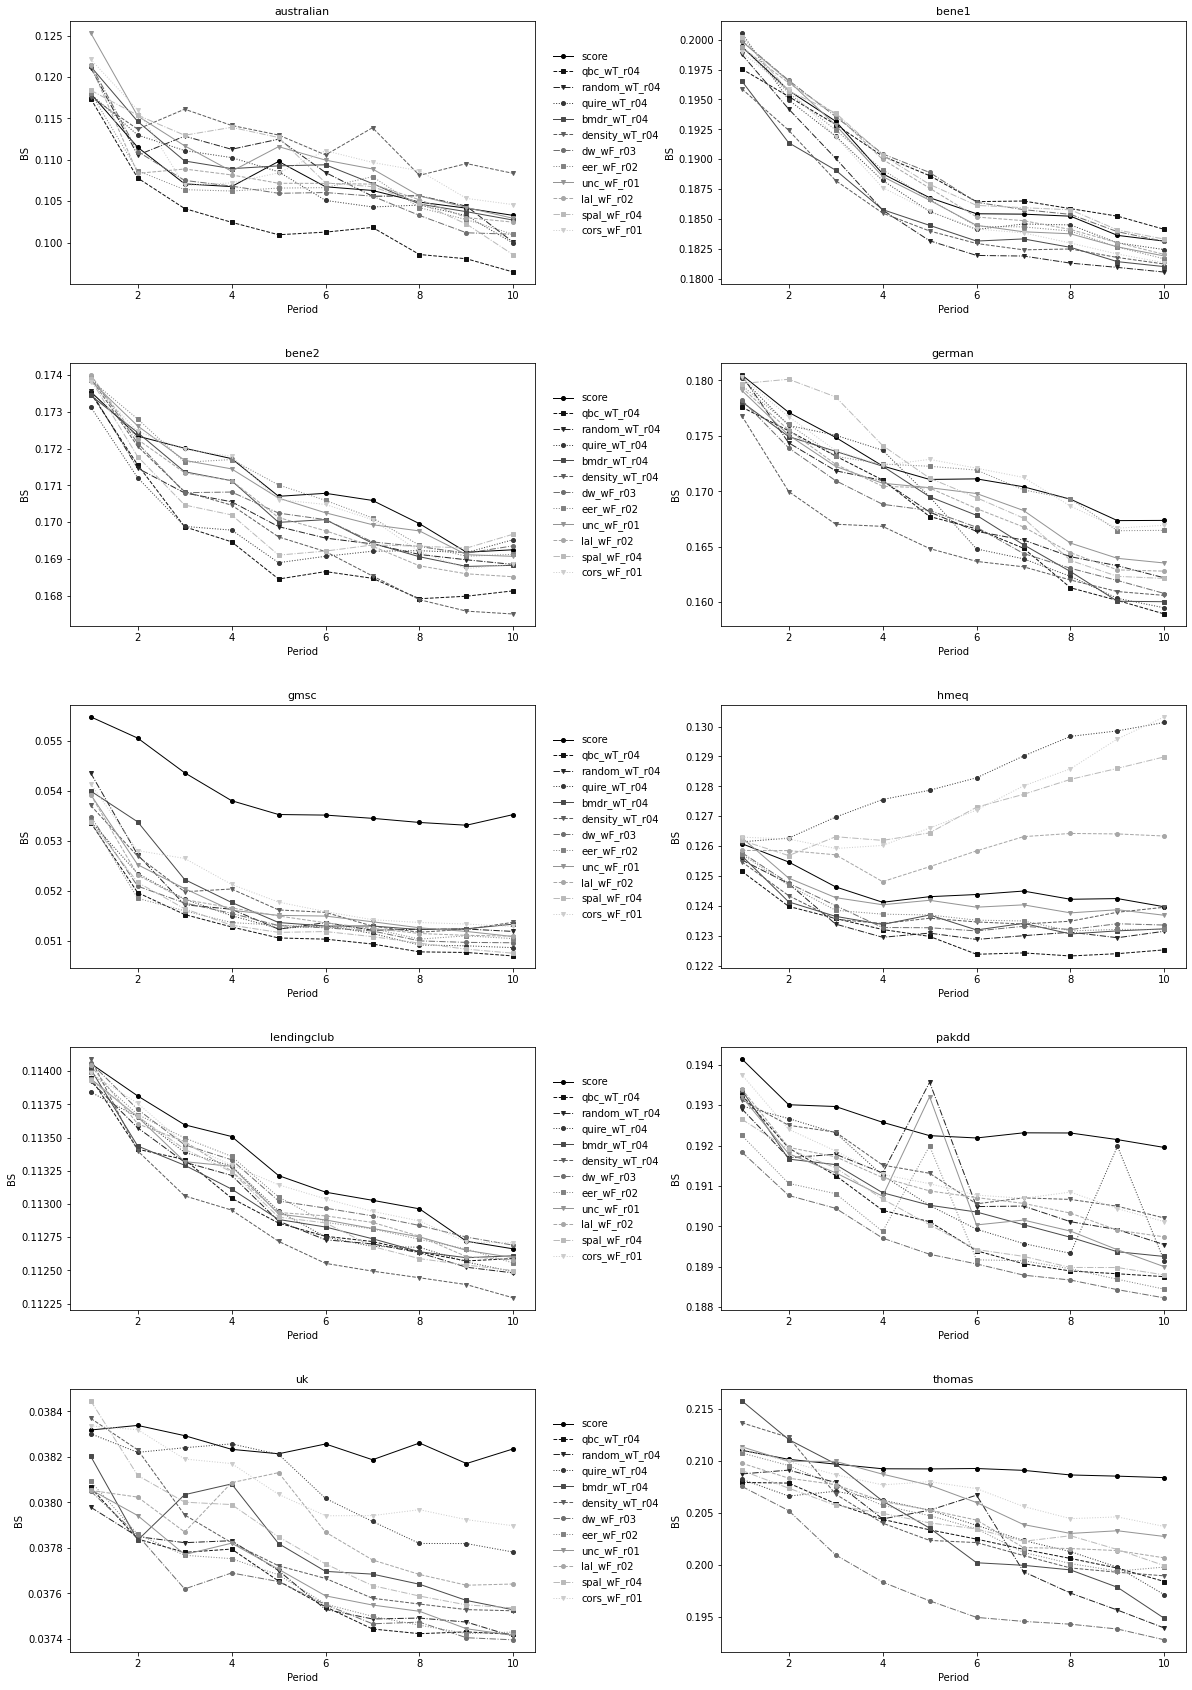

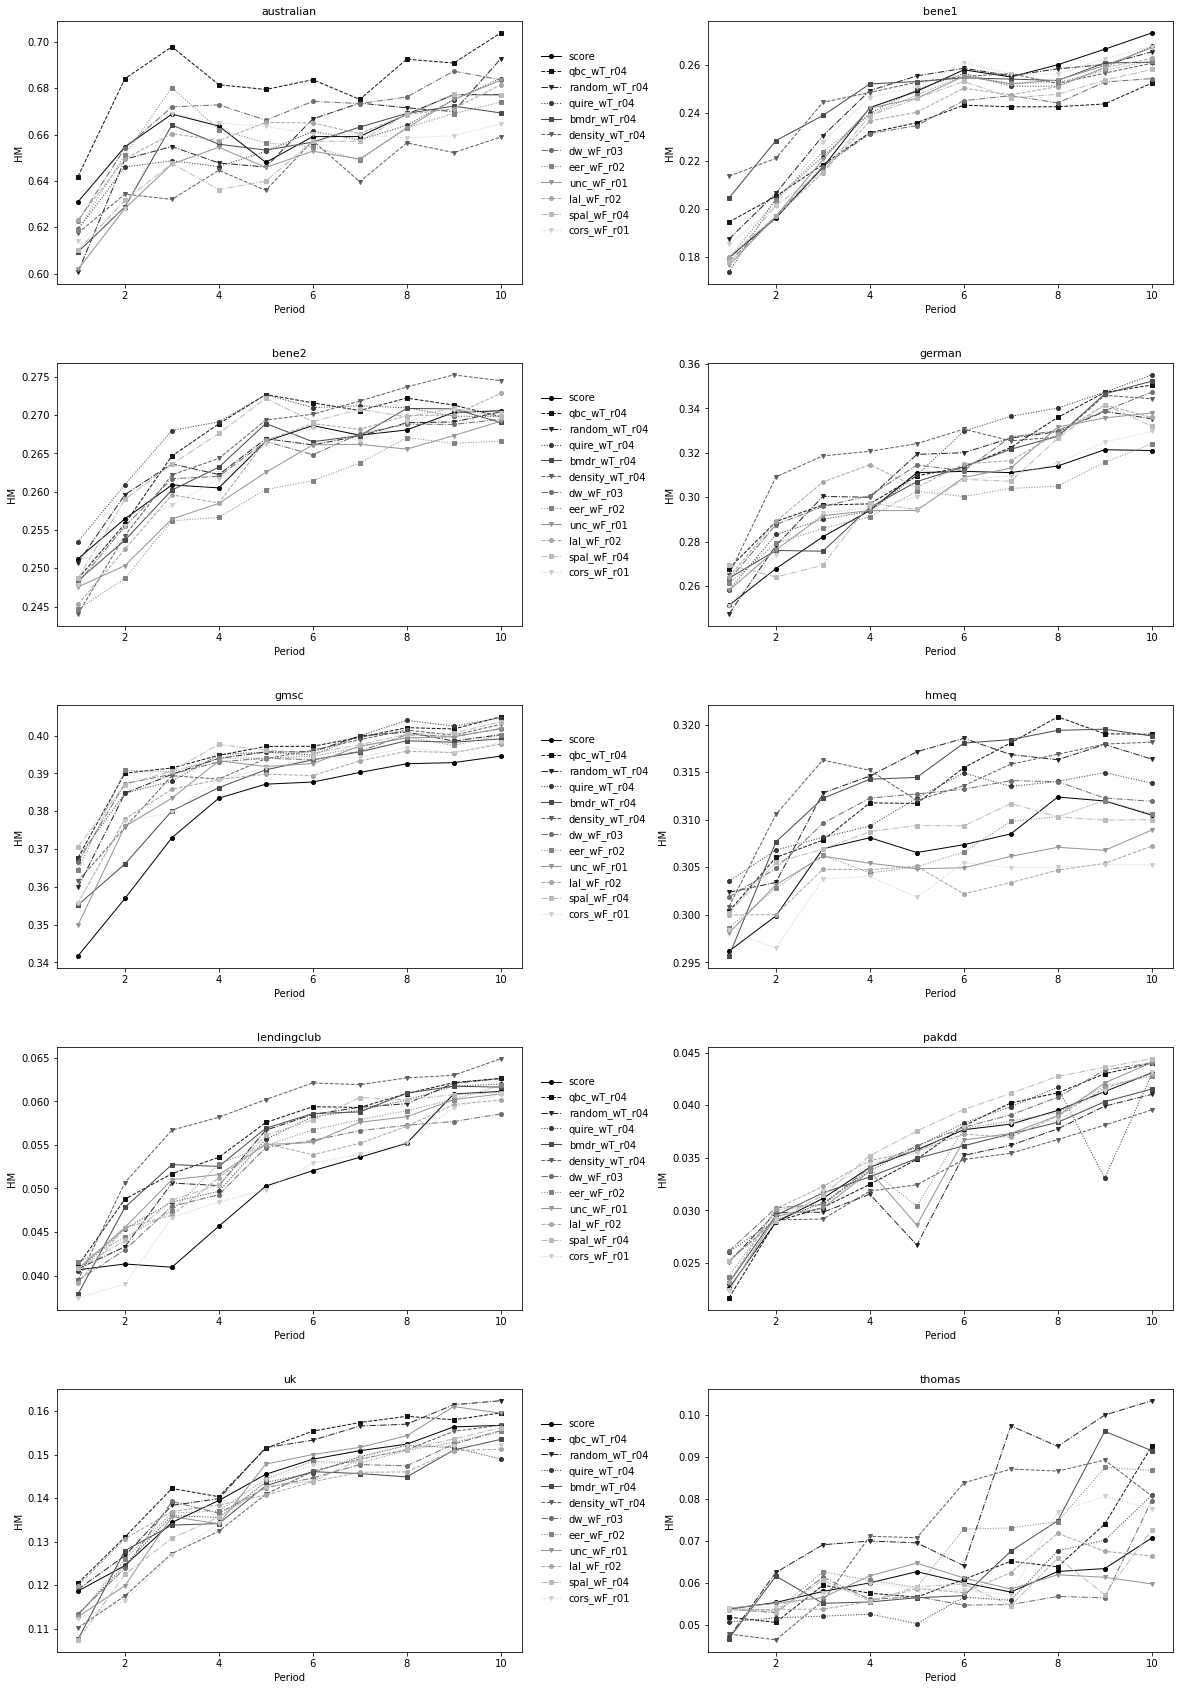

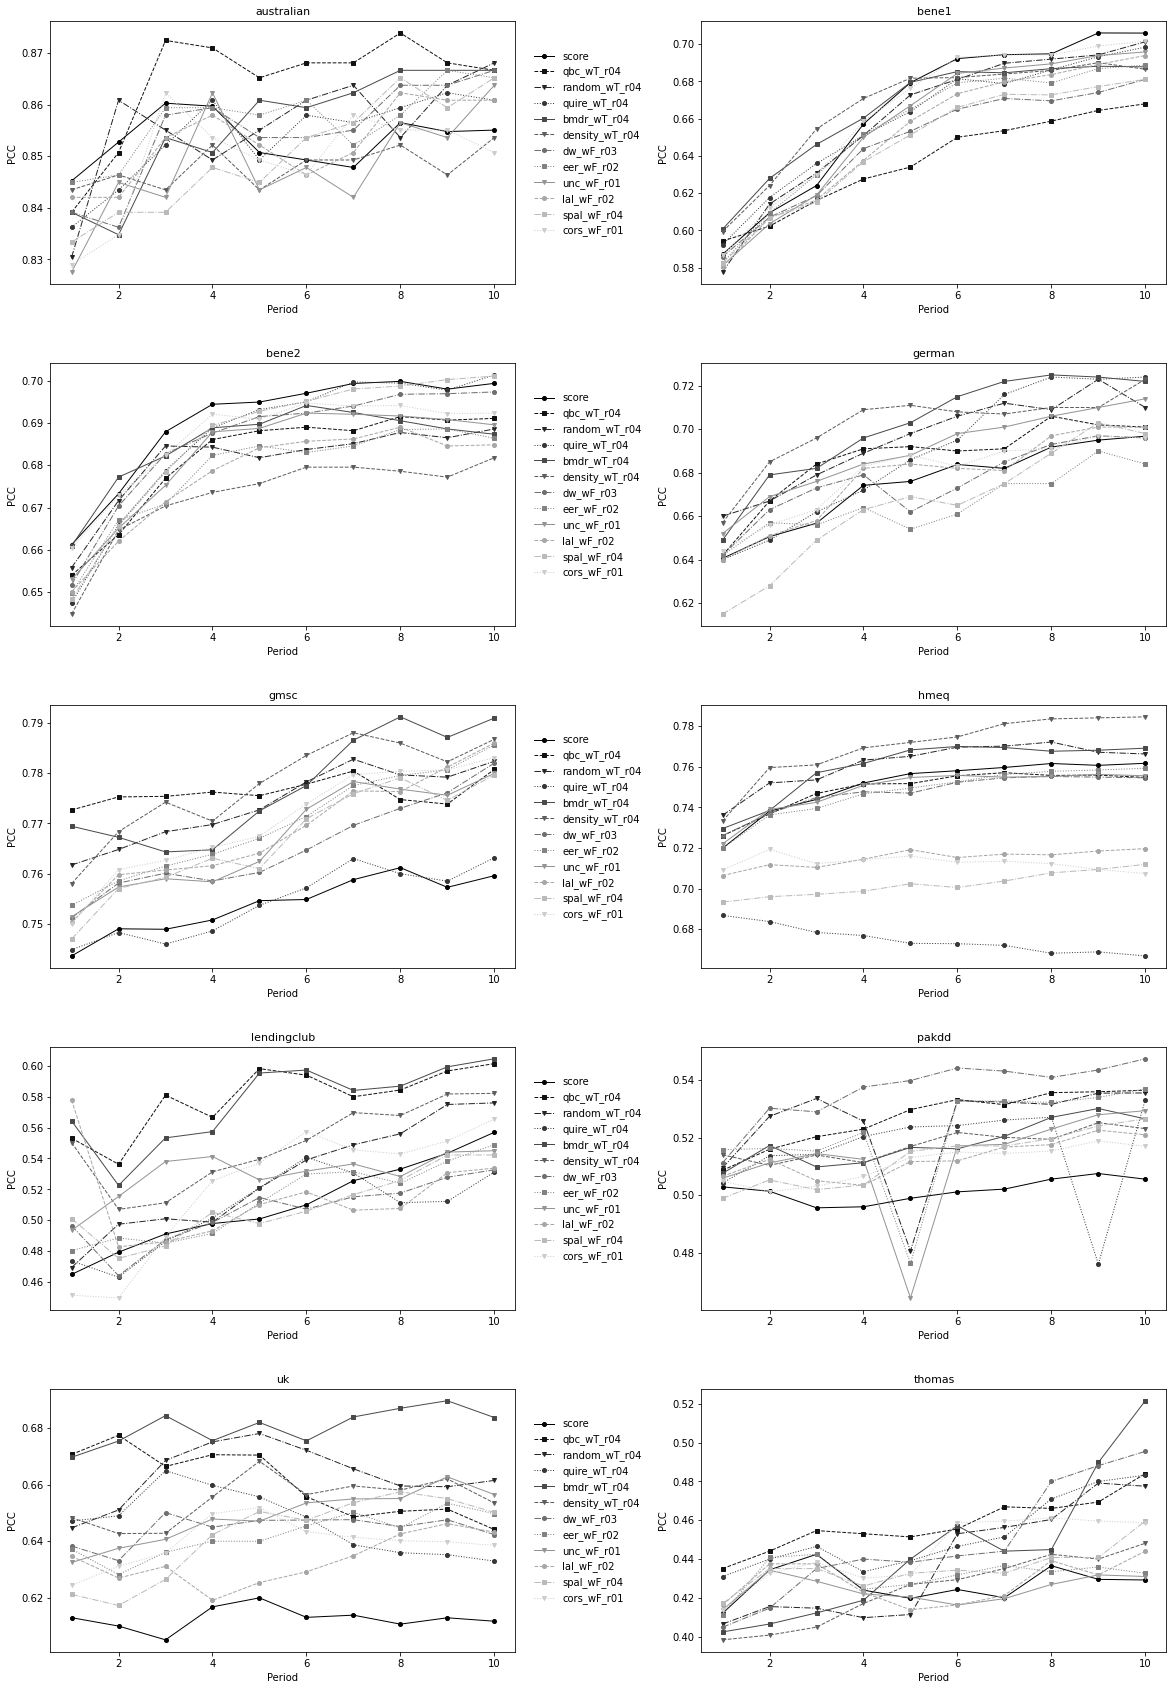

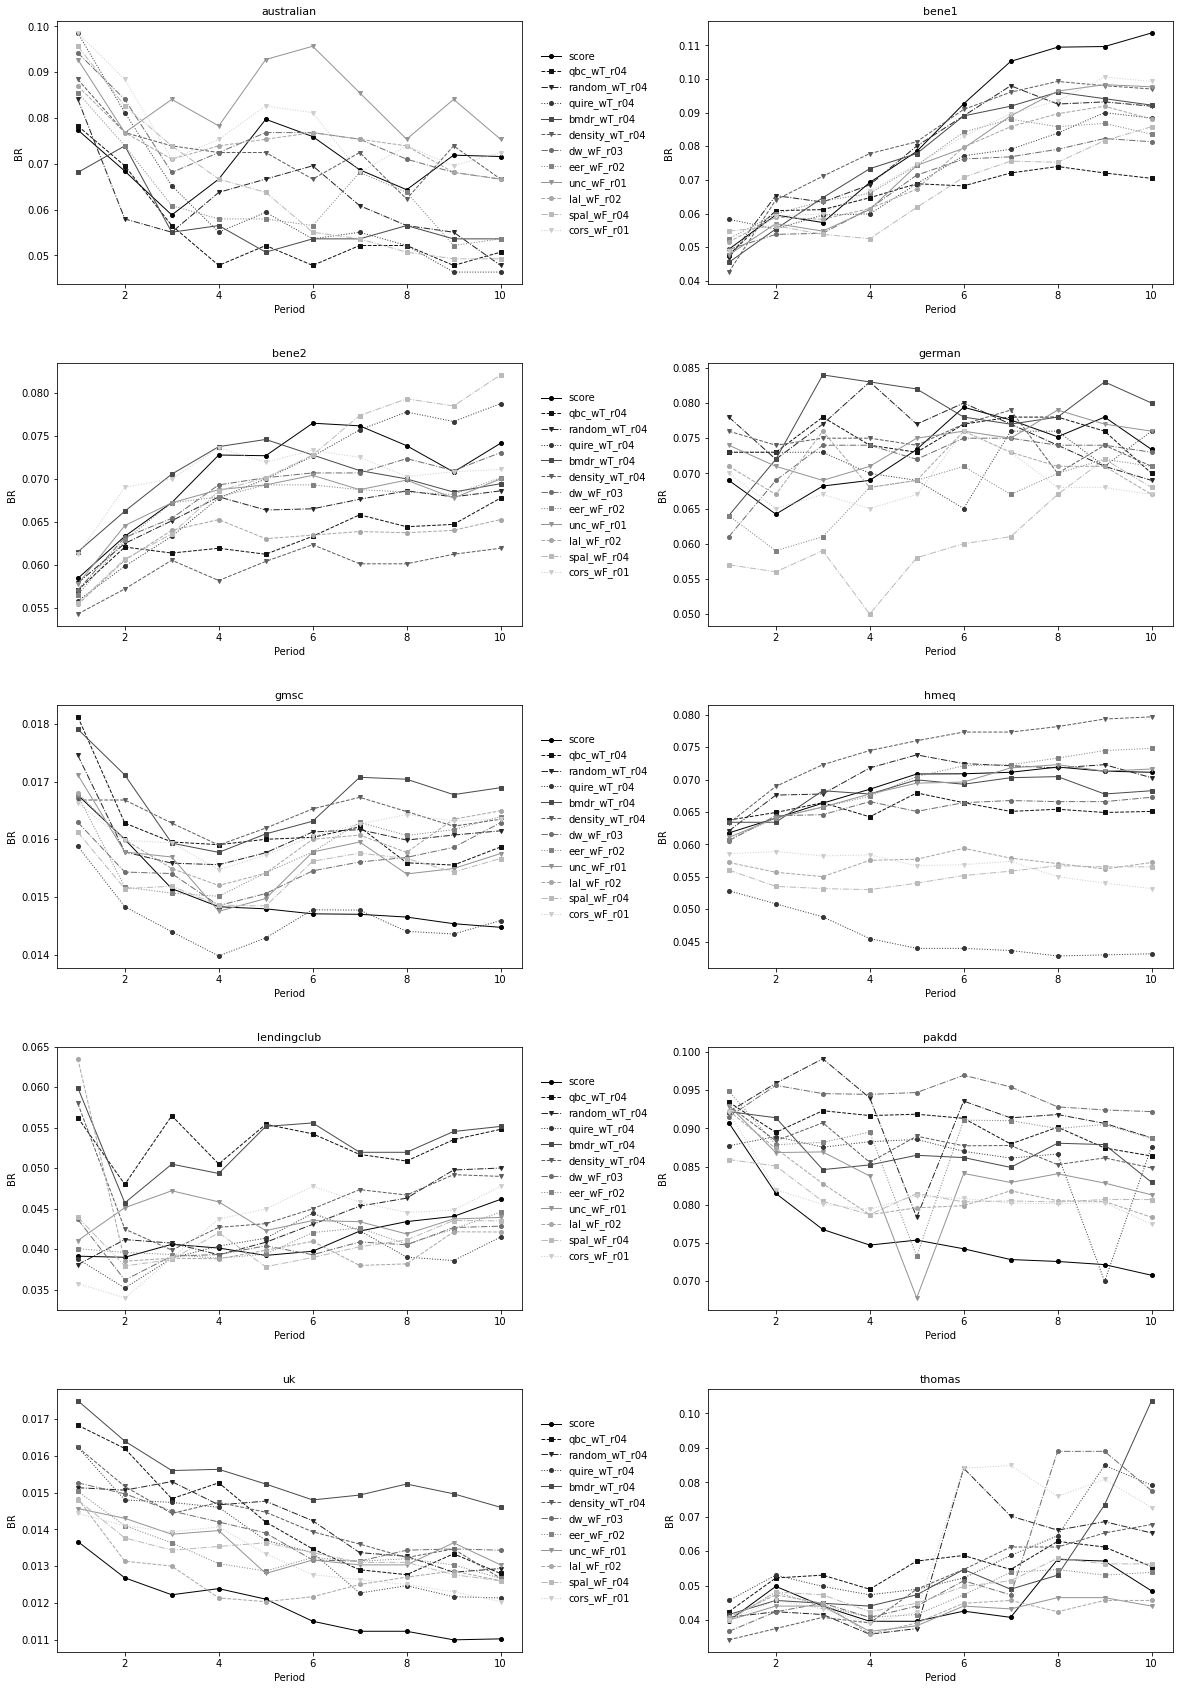

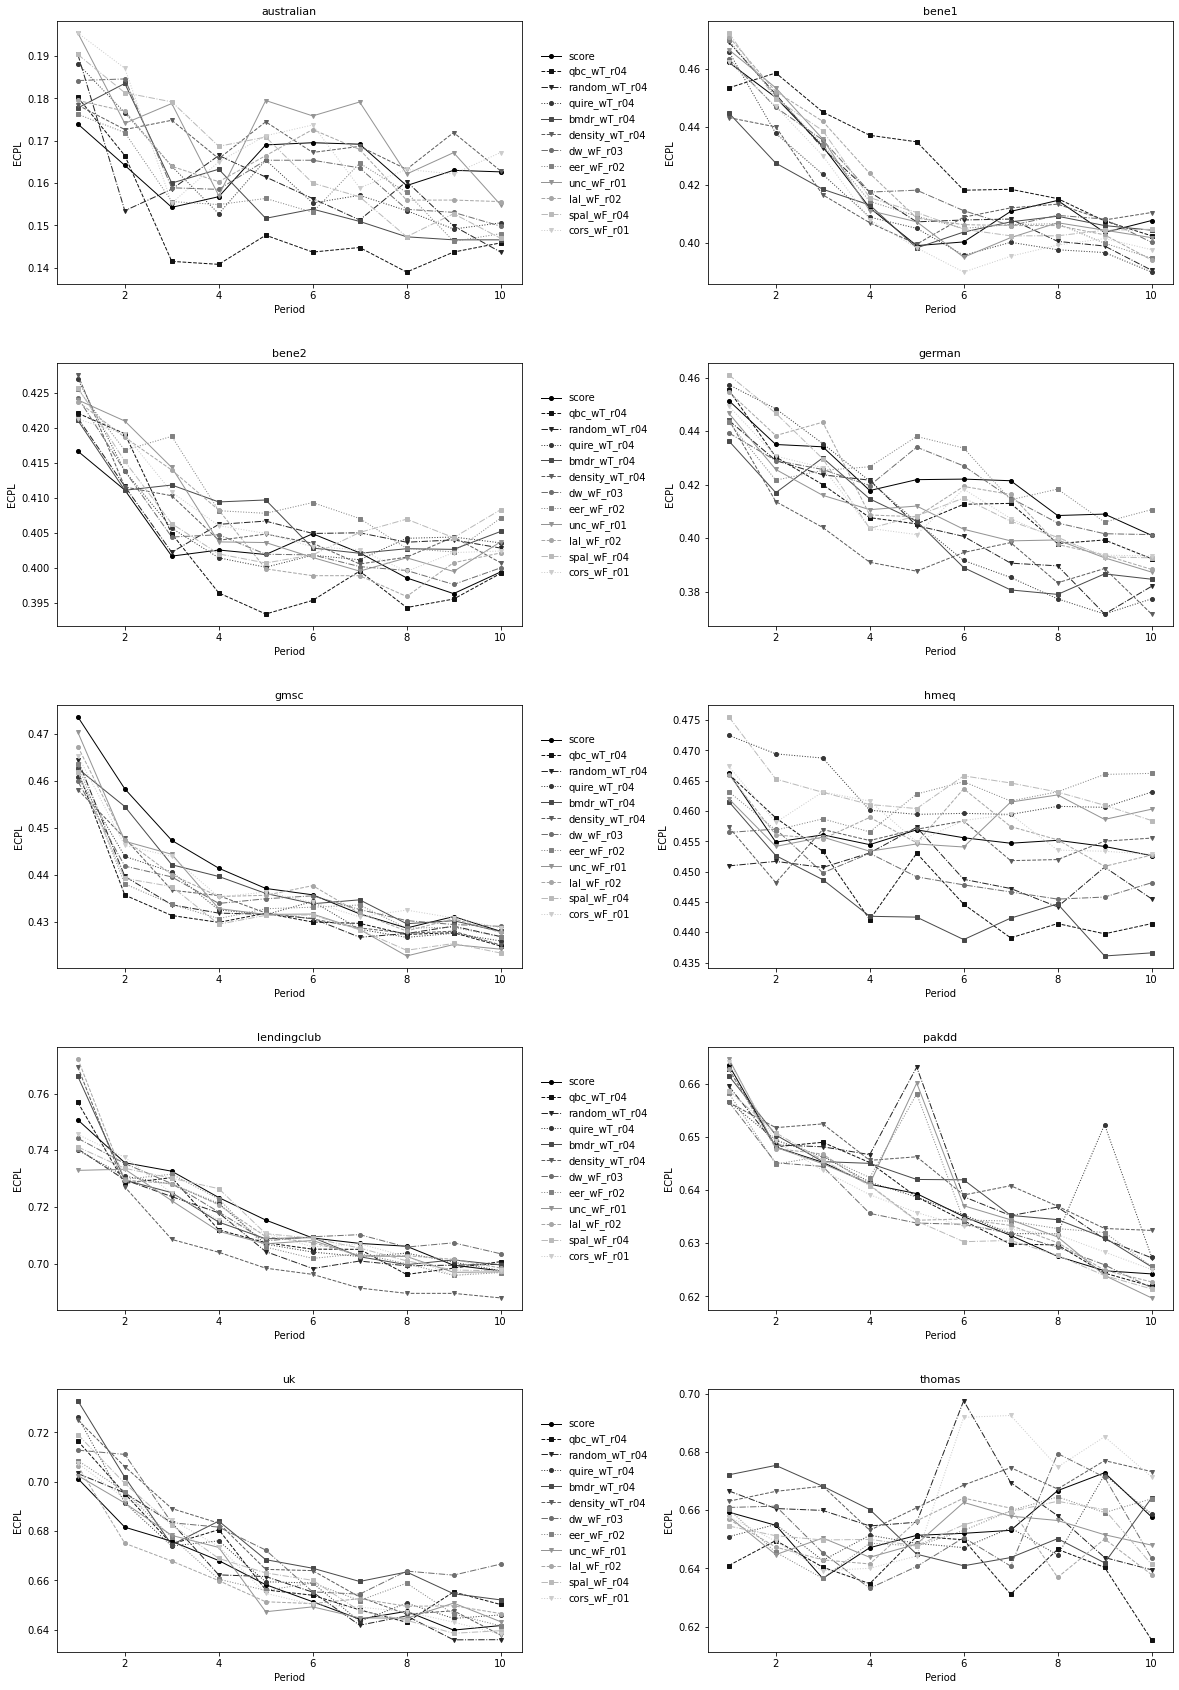

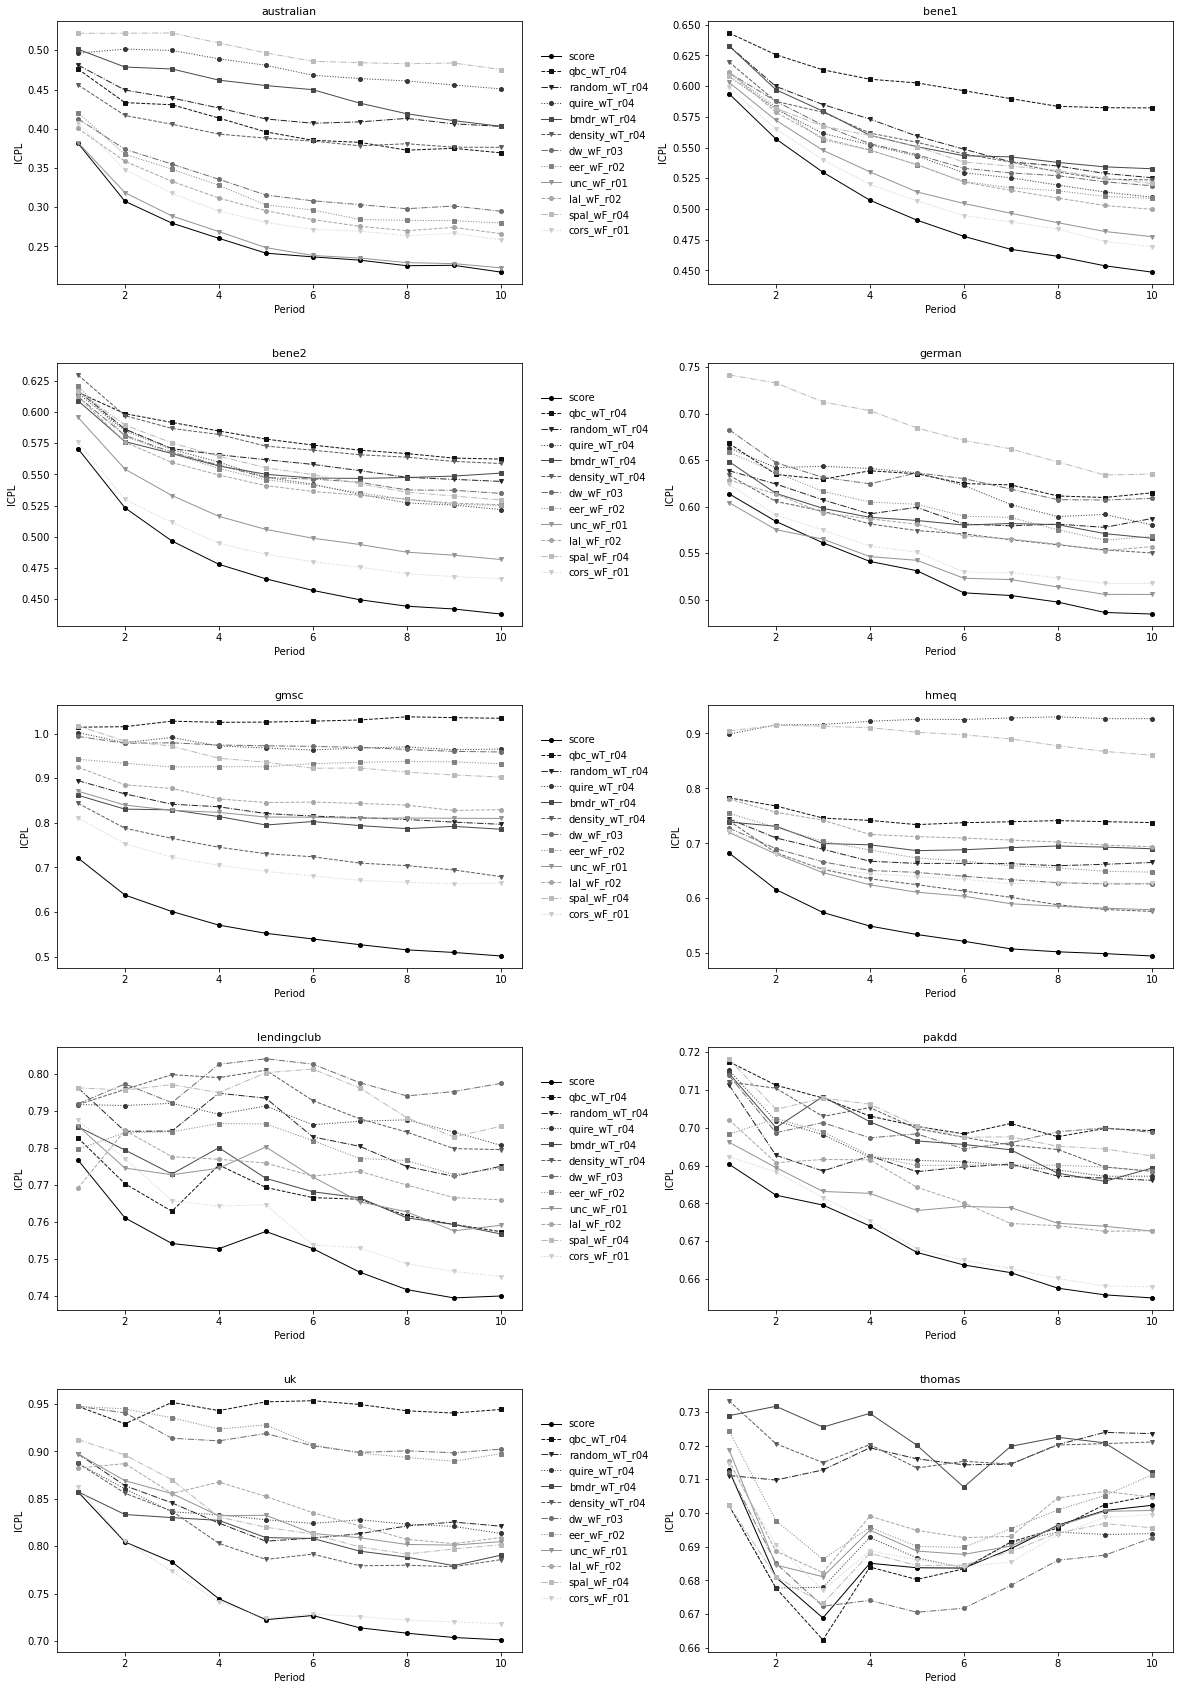

In [146]:
# Sheng & Ling (2006) for example of tight plot layout.
# Yang & Loog

col = test_results['overall'].index[0:12]
for m,s,p in metric_tuples:
  fig = plt.figure(figsize = (20, 30))
  
  for i in enumerate(dataset_list):
    #print(f'{i[1]}_{m}')
    data = performance_sub.loc[performance_sub.index.str.contains(f'{i[1]}_{m}')].loc[:,best_performers['overall']]
    data = data.loc[:,col]
    data.index = range(1,11)
    #print(m, "\n",data)
    plt.subplot(5, 2, i[0]+1)

    #color=iter(cm.rainbow(np.linspace(0,1,len(data.columns))))
    color=iter(cm.gray(np.linspace(0,0.8,len(data.columns))))
    lines = cycle(["-","--","-.",":"])
    #lines = cycle(["-",":"])
    markers = cycle(['o','s','v'])
    #color=cycle(['k','c', 'y','m'])
    #color=cycle(['r', 'g', 'b', 'k'])
    #color=cycle(['0.0', '0.2', '0.6', '0.8'])

    for c in data.columns:
      #l=next(lines)
      #d = next(markers)
      plt.plot(data.loc[:,c], 
               c=next(color), 
               ls=next(lines), 
               marker = next(markers),
               label = c,  linewidth = 1,
               markersize=4)
      plt.xlabel('Period', fontsize = 10)
      plt.title(i[1].replace('_nobins',''),fontsize = 11)
      plt.ylabel(s, fontsize = 10)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
      #plt.legend(prop = {'size': 8}, loc=p, fancybox=True, shadow=False, ncol=3) #loc='upper center', bbox_to_anchor=(0.7, 0.4),

      if i[0]%2==0:
        plt.legend(prop = {'size': 10}, fancybox=False, shadow=False, ncol=1, bbox_to_anchor=(1.08, -0.1, 0.2, 1.), borderaxespad=0.,frameon=False)
      
      fig.subplots_adjust(hspace=0.3,wspace=0.4)
      #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
  plt.savefig(f'generational_plots/{s}_alt.png', bbox_inches='tight', pad_inches=0.5)

## mean ranks of best 6 models + score; across datasets, over generations

In [147]:
# get the best performing version of each model
# for each combination of metric, data and generation, rank the models and then average over datasets
# result: each models' average rank for metric m in generation g
# further shrink the data by only keeping the best 7 models as per the main results table
index_names=[]
mean_ranks=[]
for s in metrics_list:
  for g in range(1,11):
    index_names.append(f'{s}_{g}')
    if s in['roc_auc','h-measure', 'pcc']:
      mean_ranks.append(performance_sub.loc[performance_sub.index.str.contains(f'{s}_g{g}$')].loc[:,best_performers['overall']].rank(axis=1, ascending=False).mean(axis=0))
    else:
      mean_ranks.append(performance_sub.loc[performance_sub.index.str.contains(f'{s}_g{g}$')].loc[:,best_performers['overall']].rank(axis=1, ascending=True).mean(axis=0))

generational_ranks = pd.DataFrame(mean_ranks,columns=best_performers['overall'], index=index_names)
generational_ranks


score  random_wT_r04  unc_wF_r01  qbc_wT_r04  \
roc_auc_1                6.5            6.0        8.05         5.3   
roc_auc_2                8.3            4.3        8.00         5.2   
roc_auc_3                8.1            4.8        7.50         5.4   
roc_auc_4                7.2            5.5        6.80         5.7   
roc_auc_5                6.7            5.3        7.70         4.2   
...                      ...            ...         ...         ...   
total_internal_cpl_6     1.2            7.8        3.90         9.3   
total_internal_cpl_7     1.3            8.0        3.50        10.0   
total_internal_cpl_8     1.6            8.0        3.90         9.6   
total_internal_cpl_9     1.5            8.2        3.70         9.9   
total_internal_cpl_10    1.5            8.3        3.80        10.0   

                       dw_wF_r03  cors_wF_r01  density_wT_r04  eer_wF_r02  \
roc_auc_1                    6.8         7.95             6.5         5.8   
roc_auc_2                    7.1         8.90             7.1         5.4   
roc_auc_3                    6.6         7.50             6.6         6.3   
roc_auc_4                    6.6         6.80             7.2         6.5   
roc_auc_5                    7.5         6.90             6.7         8.1   
...                          ...          ...             ...         ...   
total_internal_cpl_6         7.8         2.70             7.4         7.1   
total_internal_cpl_7         8.1         2.40             7.0         7.1   
total_internal_cpl_8         8.2         2.40             6.8         7.0   
total_internal_cpl_9         8.1         2.70             6.8         7.0   
total_internal_cpl_10        8.0         2.70             6.7         7.1   

                       lal_wF_r02  quire_wT_r04  bmdr_wT_r04  spal_wF_r04  
roc_auc_1                     7.4           4.9          7.1          5.7  
roc_auc_2                     6.2           6.1          4.4          7.0  
roc_auc_3                     7.4           6.0          5.7          6.1  
roc_auc_4                     6.5           6.2          7.1          5.9  
roc_auc_5                     7.8           5.2          6.4          5.5  
...                           ...           ...          ...          ...  
total_internal_cpl_6          6.0           8.2          7.2          9.4  
total_internal_cpl_7          5.8           8.2          7.8          8.8  
total_internal_cpl_8          6.0           8.3          7.4          8.8  
total_internal_cpl_9          5.9           8.1          7.4          8.7  
total_internal_cpl_10         5.9           7.8          7.5          8.7  

[70 rows x 12 columns]

In [148]:
#take score plus top 6 AL models
col = test_results['overall'].index[0:7] 
generational_ranks = generational_ranks.loc[:,col]
generational_ranks

score  qbc_wT_r04  random_wT_r04  quire_wT_r04  \
roc_auc_1                6.5         5.3            6.0           4.9   
roc_auc_2                8.3         5.2            4.3           6.1   
roc_auc_3                8.1         5.4            4.8           6.0   
roc_auc_4                7.2         5.7            5.5           6.2   
roc_auc_5                6.7         4.2            5.3           5.2   
...                      ...         ...            ...           ...   
total_internal_cpl_6     1.2         9.3            7.8           8.2   
total_internal_cpl_7     1.3        10.0            8.0           8.2   
total_internal_cpl_8     1.6         9.6            8.0           8.3   
total_internal_cpl_9     1.5         9.9            8.2           8.1   
total_internal_cpl_10    1.5        10.0            8.3           7.8   

                       bmdr_wT_r04  density_wT_r04  dw_wF_r03  
roc_auc_1                      7.1             6.5        6.8  
roc_auc_2                      4.4             7.1        7.1  
roc_auc_3                      5.7             6.6        6.6  
roc_auc_4                      7.1             7.2        6.6  
roc_auc_5                      6.4             6.7        7.5  
...                            ...             ...        ...  
total_internal_cpl_6           7.2             7.4        7.8  
total_internal_cpl_7           7.8             7.0        8.1  
total_internal_cpl_8           7.4             6.8        8.2  
total_internal_cpl_9           7.4             6.8        8.1  
total_internal_cpl_10          7.5             6.7        8.0  

[70 rows x 7 columns]

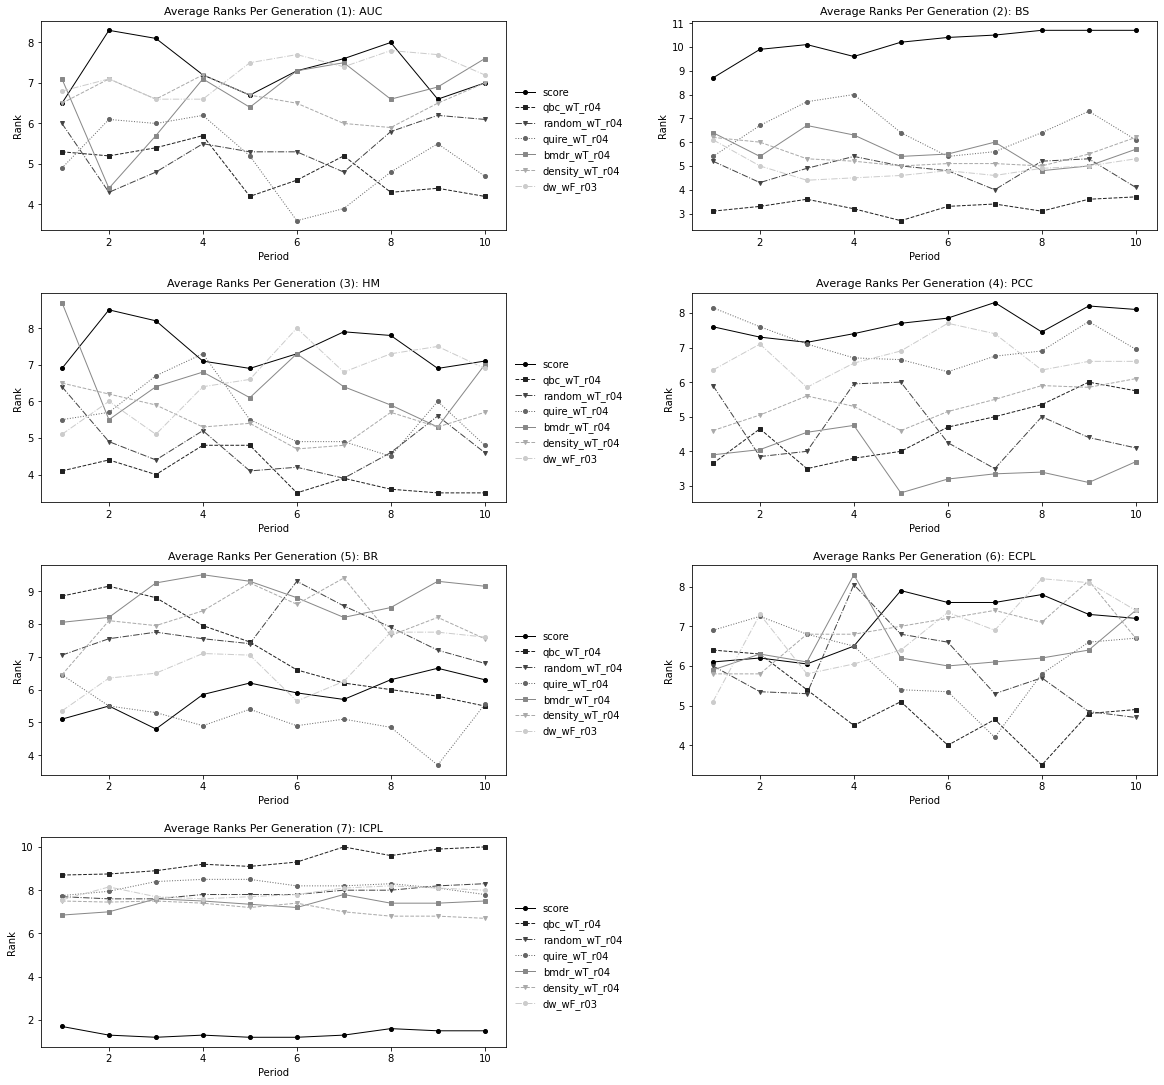

In [152]:
fig = plt.figure(figsize = (20, 30))
for i in enumerate(metric_tuples):
  m=i[1][0] #full metric name
  s=i[1][1] #short form
  p=i[1][2] #position of legend matchin shape of curves for respective metric

  data = generational_ranks.loc[generational_ranks.index.str.contains(f'{m}')]
  data.index = range(1,11)
  plt.subplot(4, 2, i[0]+1)

  color=iter(cm.gray(np.linspace(0,0.8,len(data.columns))))
  lines = cycle(["-","--","-.",":"])
  markers = cycle(['o','s','v'])

  for c in data.columns:
    #l=next(lines)
    #d = next(markers)
    plt.plot(data.loc[:,c], 
             c=next(color), 
              ls=next(lines), 
              marker = next(markers),
              label = c,  linewidth = 1,
              markersize=4)
    plt.xlabel('Period', fontsize = 10)
    plt.title(f'Average Ranks Per Generation ({i[0]+1}): {s}',fontsize = 11)
    plt.ylabel('Rank', fontsize = 10)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
    #plt.legend(prop = {'size': 8}, loc=p, fancybox=True, shadow=False, ncol=3) #loc='upper center', bbox_to_anchor=(0.7, 0.4),

    if i[0]%2==0:
      plt.legend(prop = {'size': 10}, fancybox=False, shadow=False, ncol=1, bbox_to_anchor=(1.08, -0.25, 0.2, 1.), borderaxespad=1.,frameon=False)
    
    fig.subplots_adjust(top=0.6,hspace=0.3,wspace=0.4)
    #fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(f'generational_plots/top6_ranks.png', bbox_inches='tight', pad_inches=0.5)

In [ ]:
generational_ranks.loc[generational_ranks.index.str.contains(f'roc_auc')]

score  random_wT_r04  unc_wF_r01  qbc_wT_r04  dw_wF_r03  \
roc_auc_1     6.5            6.0        8.05         5.3        6.8   
roc_auc_2     8.3            4.3        8.00         5.2        7.1   
roc_auc_3     8.1            4.8        7.50         5.4        6.6   
roc_auc_4     7.2            5.5        6.80         5.7        6.6   
roc_auc_5     6.7            5.3        7.70         4.2        7.5   
roc_auc_6     7.3            5.3        7.50         4.6        7.7   
roc_auc_7     7.6            4.8        6.50         5.2        7.4   
roc_auc_8     8.0            5.8        6.80         4.3        7.8   
roc_auc_9     6.6            6.2        5.90         4.4        7.7   
roc_auc_10    7.0            6.1        6.00         4.2        7.2   

            cors_wF_r01  density_wT_r04  eer_wF_r02  lal_wF_r02  quire_wT_r04  \
roc_auc_1          7.95             6.5         5.8         7.4           4.9   
roc_auc_2          8.90             7.1         5.4         6.2           6.1   
roc_auc_3          7.50             6.6         6.3         7.4           6.0   
roc_auc_4          6.80             7.2         6.5         6.5           6.2   
roc_auc_5          6.90             6.7         8.1         7.8           5.2   
roc_auc_6          7.10             6.5         8.2         7.9           3.6   
roc_auc_7          7.80             6.0         8.8         7.6           3.9   
roc_auc_8          7.60             5.9         8.4         7.6           4.8   
roc_auc_9          7.20             6.5         8.3         7.6           5.5   
roc_auc_10         7.50             7.0         8.0         8.1           4.7   

            bmdr_wT_r04  spal_wF_r04  
roc_auc_1           7.1          5.7  
roc_auc_2           4.4          7.0  
roc_auc_3           5.7          6.1  
roc_auc_4           7.1          5.9  
roc_auc_5           6.4          5.5  
roc_auc_6           7.3          5.0  
roc_auc_7           7.5          4.9  
roc_auc_8           6.6          4.4  
roc_auc_9           6.9          5.2  
roc_auc_10          7.6          4.6

### rank tests

In [ ]:
performance_sub.loc[performance_sub.index.str.contains(f'roc_auc_g5')].loc[:,best_performers['overall']].rank(axis=1, ascending=False).mean()

score             6.7
random_wT_r04     5.3
unc_wF_r01        7.7
qbc_wT_r04        4.2
dw_wF_r03         7.5
cors_wF_r01       6.9
density_wT_r04    6.7
eer_wF_r02        8.1
lal_wF_r02        7.8
quire_wT_r04      5.2
bmdr_wT_r04       6.4
spal_wF_r04       5.5
dtype: float64

In [ ]:
performance_sub_ranks.loc[performance_sub_ranks.index.str.contains(f'roc_auc_g5')].loc[:,best_performers['overall']].rank(axis=1, ascending=True).mean()

score             6.7
random_wT_r04     5.3
unc_wF_r01        7.7
qbc_wT_r04        4.2
dw_wF_r03         7.5
cors_wF_r01       6.9
density_wT_r04    6.7
eer_wF_r02        8.1
lal_wF_r02        7.8
quire_wT_r04      5.2
bmdr_wT_r04       6.4
spal_wF_r04       5.5
dtype: float64

## mean ranks per RATIO across weight options

In [327]:
ratios_list = ["01","02","03","04","05"] #,0.2,0.3,0.4,0.5
# average over 100 rows (all datasets and generations)
model_order = [i.split('_', 1)[0] for i in test_results['overall'].index[0:12]] # get the base model names ordered by performance as in the main results table
columns=[i.split('_', 1)[0] for i in performance_sub.filter(regex='wF_r01|score').columns] # get the current order of models as in the data used for the plot
print('alphabetical order:',columns)
print('custom order:',model_order)

w_ratio_ranks = {}
for w in weights_list:
  ranks=[]
  index_names=[]

  for s in metrics_list:

    for r in enumerate(ratios_list):
      index_names.append(f'{s}_{r[1]}')

      if s in ['roc_auc','h-measure','pcc','f1','average_precision','precision','recall','bad_ratio_rejects','balanced_accuracy','tn','tp']:
        ranks.append(performance_sub.filter(regex=f'{w}_r{r[1]}|score').loc[performance_sub.index.str.contains(f'{s}')].rank(axis="columns", ascending = False).mean().rank().values)

      else:
        ranks.append(performance_sub.filter(regex=f'{w}_r{r[1]}|score').loc[performance_sub.index.str.contains(f'{s}')].rank(axis="columns", ascending = True).mean().rank().values)
        
  #ratio_ranks = pd.DataFrame(ranks,columns=columns, index=index_names)
  #ratio_ranks = ratio_ranks.loc[:,model_order] #re-order the data to match the columns 
  w_ratio_ranks[w]=pd.DataFrame(ranks,columns=columns, index=index_names).loc[:,model_order]

average_ratio_ranks = pd.concat((w_ratio_ranks['wF'], w_ratio_ranks['wT']))
average_ratio_ranks = average_ratio_ranks.groupby(average_ratio_ranks.index)

alphabetical order: ['bmdr', 'cors', 'density', 'dw', 'eer', 'lal', 'qbc', 'quire', 'random', 'score', 'spal', 'unc']
custom order: ['score', 'qbc', 'random', 'quire', 'bmdr', 'density', 'dw', 'eer', 'unc', 'lal', 'spal', 'cors']


In [346]:
w_ratio_ranks['wF']

score   qbc  random  quire  bmdr  density    dw   eer  \
roc_auc_01               9.0   5.0     4.0    2.0   3.0     11.0  10.0   8.0   
roc_auc_02               9.0   1.0    12.0    2.0   3.0      7.0   6.0   8.0   
roc_auc_03              11.0   7.0     3.0    1.0   5.0      4.0  10.0   9.0   
roc_auc_04               8.0   4.0     5.0    1.0   3.0      6.0  12.0   9.0   
roc_auc_05              11.0   1.0    12.0    3.0   6.0      5.0   8.0   9.0   
brier_01                12.0   3.0     5.0    7.0  11.0      8.0   4.0   2.0   
brier_02                12.0   2.0     9.0    6.0  10.0      7.0   4.0   3.0   
brier_03                12.0   4.0     7.0    8.0   9.0      5.0   3.0   2.0   
brier_04                12.0   3.0     7.0    8.0   6.0      5.0   4.0   2.0   
brier_05                12.0   3.0    11.0    8.0   9.0      5.0   4.0   2.0   
h-measure_01             5.0   6.0     3.0    1.0   4.0      9.0  11.0  10.0   
h-measure_02             8.5   3.0    11.0    1.0   8.5      4.0   2.0   7.0   
h-measure_03            12.0   6.0     2.0    7.0   9.0      3.0   8.0   4.0   
h-measure_04            11.0   1.0     4.0    7.0   5.0      2.0   6.0   9.0   
h-measure_05            12.0   1.0    11.0    6.0  10.0      7.0   2.0   4.0   
pcc_01                  11.0   6.0     3.0   10.0   8.0      7.0   1.0   2.0   
pcc_02                  10.0   3.0     5.0    8.0   4.0      6.0   1.0   7.0   
pcc_03                   9.0   2.0     3.0   10.0   1.0      7.0   4.0   6.0   
pcc_04                   9.0   2.0     5.0   11.0   1.0      3.0   7.0   4.0   
pcc_05                   9.0   2.0     3.0   10.0   1.0      4.0   8.0   5.0   
bad_ratio_test_01        3.0  10.0     5.0    2.0   9.0      6.0  12.0  11.0   
bad_ratio_test_02        2.0  12.0     7.0    5.0  10.0      8.0  11.0   4.0   
bad_ratio_test_03        4.0  11.0     5.0    3.0  12.0      6.0  10.0   8.0   
bad_ratio_test_04        8.0  10.0     6.0    2.0  12.0      9.0   5.0  11.0   
bad_ratio_test_05        8.0   7.0    10.0    3.0  12.0     11.0   5.0   9.0   
external_cpl_01          5.0   7.0    10.0    3.0   6.0      8.0  12.0   9.0   
external_cpl_02          4.0   5.0    11.0    1.0   3.0      9.0   6.0   7.0   
external_cpl_03          4.0   9.0     1.0    7.0   5.0      3.0   2.0  10.0   
external_cpl_04          5.0   1.0     6.0    3.0   4.0      7.0   8.0   9.0   
external_cpl_05          6.0   1.0    10.0    3.0   2.0      4.0   9.0   5.0   
total_internal_cpl_01    1.0   9.0     2.0    7.0   4.0      3.0   6.0  11.0   
total_internal_cpl_02    1.0   6.0     5.0    4.0   2.0      3.0   8.0  12.0   
total_internal_cpl_03    1.0   7.0     5.0    4.0   3.0      2.0   8.0  11.0   
total_internal_cpl_04    1.0   7.0     4.0    5.0   2.0      3.0   9.0  11.0   
total_internal_cpl_05    1.0   6.0     4.0    5.0   3.0      2.0   9.0  11.0   

                        unc   lal  spal  cors  
roc_auc_01              7.0   6.0   1.0  12.0  
roc_auc_02              5.0  10.0   4.0  11.0  
roc_auc_03              6.0   8.0   2.0  12.0  
roc_auc_04             11.0  10.0   2.0   7.0  
roc_auc_05             10.0   7.0   2.0   4.0  
brier_01                1.0   6.0   9.0  10.0  
brier_02                1.0   5.0   8.0  11.0  
brier_03                1.0   6.0  11.0  10.0  
brier_04                1.0  11.0  10.0   9.0  
brier_05                1.0   6.0  10.0   7.0  
h-measure_01            7.0   8.0   2.0  12.0  
h-measure_02            5.0  10.0   6.0  12.0  
h-measure_03            1.0  10.0   5.0  11.0  
h-measure_04            3.0  12.0   8.0  10.0  
h-measure_05            3.0   9.0   5.0   8.0  
pcc_01                  4.0  12.0   9.0   5.0  
pcc_02                  2.0  12.0  11.0   9.0  
pcc_03                  5.0  12.0  11.0   8.0  
pcc_04                  8.0  12.0  10.0   6.0  
pcc_05                  6.0  12.0  11.0   7.0  
bad_ratio_test_01       8.0   1.0   7.0   4.0  
bad_ratio_test_02       9.0   1.0   3.0   6.0  
bad_ratio_test_03       9.0   1.0   2.

In [347]:
average_ratio_ranks.mean()

score  qbc  random  quire   bmdr  density    dw   eer  \
bad_ratio_test_01       2.00  9.0    7.00    4.0  10.00     5.50  11.0   7.0   
bad_ratio_test_02       1.50  8.0    7.00    3.5  11.00     8.00  10.5   5.0   
bad_ratio_test_03       3.00  8.0    6.50    3.5  12.00     7.50   8.0   9.0   
bad_ratio_test_04       5.50  8.5    8.00    2.0  12.00    10.00   5.5   9.5   
bad_ratio_test_05       8.00  7.0   10.00    3.0  12.00    11.00   5.0   9.0   
brier_01                6.50  4.0    4.00    8.0   8.50    10.00   4.0   6.5   
brier_02               10.50  1.5    7.50    8.0  10.50     6.00   4.0   3.0   
brier_03               12.00  2.5    6.50    9.0   8.50     5.00   3.5   2.5   
brier_04               12.00  2.5    6.00    8.0   6.50     5.50   4.0   1.5   
brier_05               12.00  3.0   11.00    8.0   9.00     5.00   4.0   2.0   
external_cpl_01         3.00  7.0    6.00    3.5   8.50     6.50   9.0  10.5   
external_cpl_02         2.50  4.5    8.00    2.0   6.50     5.50   6.0   7.0   
external_cpl_03         4.00  6.0    1.00    6.0   6.00     2.50   4.0  10.5   
external_cpl_04         6.00  1.0    4.00    3.0   4.00     6.00   9.0   7.5   
external_cpl_05         6.00  1.0   10.00    3.0   2.00     4.00   9.0   5.0   
h-measure_01            3.00  8.5    2.50    2.0   6.50     7.50  10.5  11.0   
h-measure_02            4.75  4.5    7.00    2.5   8.25     3.00   6.5   8.5   
h-measure_03           10.50  3.5    3.50    7.0  10.50     2.50   5.5   5.0   
h-measure_04           11.50  1.0    3.00    6.5   7.00     2.50   5.5   6.5   
h-measure_05           12.00  1.0   11.00    6.0  10.00     7.00   2.0   4.0   
pcc_01                 11.00  5.5    2.50    9.0   6.00     6.50   2.0   6.0   
pcc_02                 11.00  5.0    5.00    8.5   2.50     6.00   1.5   7.5   
pcc_03                 10.50  2.0    3.00    9.5   1.00     5.50   5.0   6.5   
pcc_04                 10.00  2.0    4.00   10.0   1.00     4.00   7.5   4.0   
pcc_05                  9.00  2.0    3.00   10.0   1.00     4.00   8.0   5.0   
roc_auc_01              5.00  8.0    3.50    3.0   4.25     8.25  10.0  10.0   
roc_auc_02              5.00  3.0    7.00    2.5   5.50     5.50   8.0  10.0   
roc_auc_03              7.50  5.0    5.00    1.0   8.00     3.00   9.5   9.5   
roc_auc_04              9.00  2.5    4.00    1.5   5.00     5.50  11.5   7.5   
roc_auc_05             11.00  1.0   12.00    3.0   6.00     5.00   8.0   9.0   
total_internal_cpl_01   1.00  9.0    2.25    6.5   4.00     2.75   5.5  11.5   
total_internal_cpl_02   1.00  7.0    4.50    5.0   2.00     3.00   7.5  12.0   
total_internal_cpl_03   1.00  7.0    5.00    4.0   3.00     2.00   8.0  11.5   
total_internal_cpl_04   1.00  7.0    4.00    5.0   2.50     2.50   8.5  11.0   
total_internal_cpl_05   1.00  6.0    4.00    5.0   3.00     2.00   9.0  11.0   

                        unc   lal  spal  cors  
bad_ratio_test_01      10.0   1.5   7.0   4.0  
bad_ratio_test_02      10.0   5.0   4.0   4.5  
bad_ratio_test_03      10.0   1.0   2.5   7.0  
bad_ratio_test_04       6.5   3.5   1.0   6.0  
bad_ratio_test_05       6.0   1.0   2.0   4.0  
brier_01                1.5   8.0   8.5   8.5  
brier_02                1.5   6.0  10.0   9.5  
brier_03                1.5   7.5  11.0   8.5  
brier_04                2.0  10.5  10.5   9.0  
brier_05                1.0   6.0  10.0   7.0  
external_cpl_01         5.5   9.5   3.5   5.5  
external_cpl_02        10.0   5.5   9.0  11.5  
external_cpl_03        10.5   8.5   7.0  12.0  
external_cpl_04        11.0  11.5   5.0  10.0  
external_cpl_05         8.0  12.0  11.0   7.0  
h-measure_01            6.0   8.0   3.0   9.5  
h-measure_02            5.0   8.5   7.5  12.0  
h-measure_03            2.5   9.0   8.0  10.5  
h-measure_04            5.0  11.5   8.0  10.0  
h-measure_05            3.0   9.0   5.0   8.0  
pcc_01                  2.5  12.0   9.0   6.0  
pcc_02                  2.5   8.0  11.0   9.5  
pcc_03                  5.0  11.0  11.

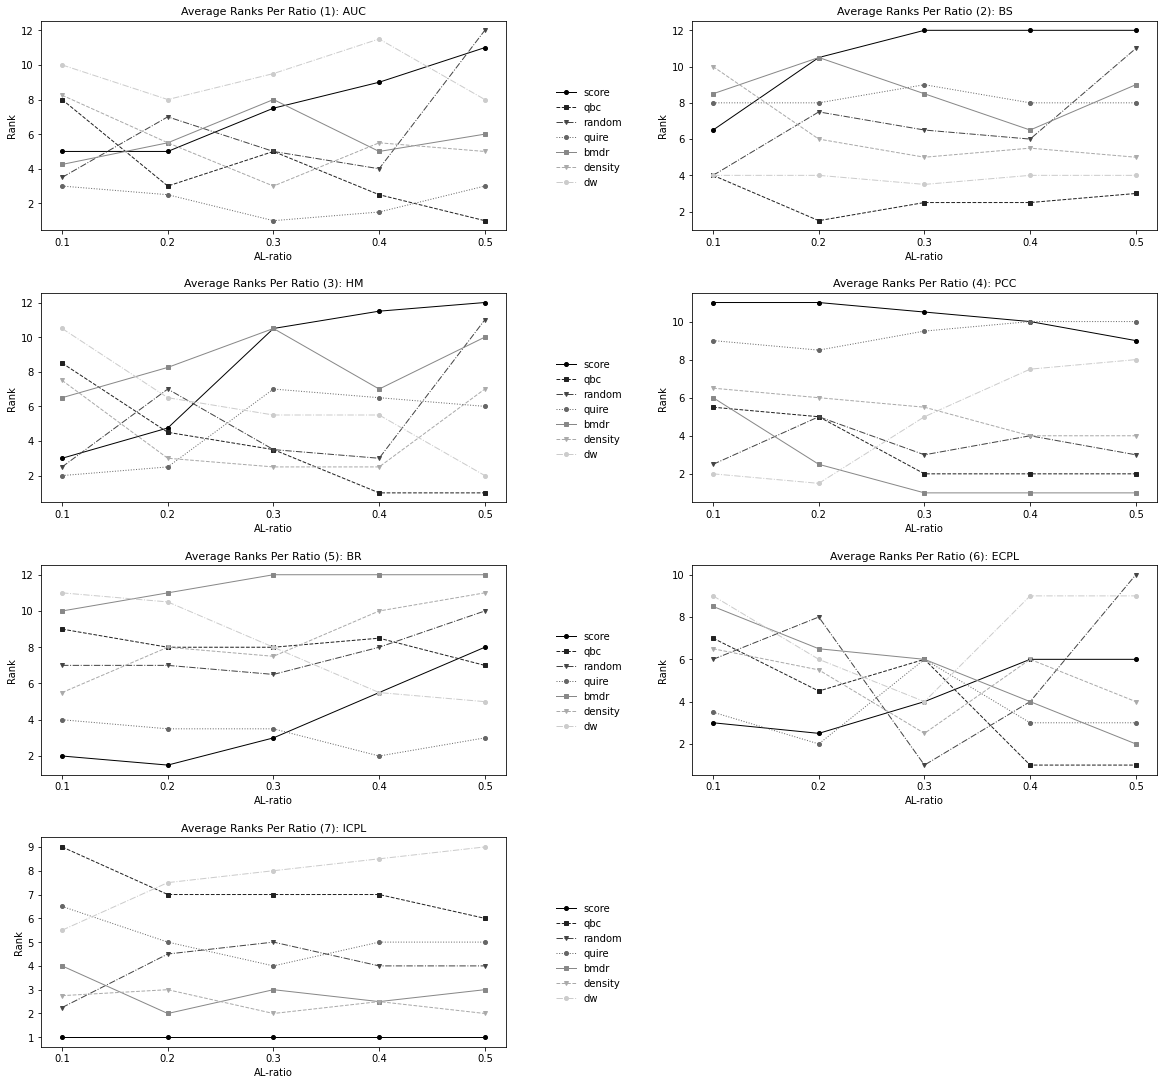

In [342]:
fig = plt.figure(figsize = (20, 30))
for i in enumerate(metric_tuples):
  m=i[1][0] #full metric name
  s=i[1][1] #short form
  p=i[1][2] #position of legend matchin shape of curves for respective metric

  data = pd.DataFrame(average_ratio_ranks.mean())
  data = data.loc[data.index.str.contains(f'{m}')].iloc[:,:7]
  data.index = np.linspace(0.1,0.5,5)
  #print(data)
  plt.subplot(4, 2, i[0]+1)

  color=iter(cm.gray(np.linspace(0,0.8,len(data.columns))))
  lines = cycle(["-","--","-.",":"])
  markers = cycle(['o','s','v'])

  for c in data.columns:
    plt.plot(data.loc[:,c], 
             c=next(color), 
              ls=next(lines), 
              marker = next(markers),
              label = c,  linewidth = 1,
              markersize=4)
    plt.xlabel('AL-ratio', fontsize = 10)
    plt.title(f'Average Ranks Per Ratio ({i[0]+1}): {s}',fontsize = 11)
    plt.ylabel('Rank', fontsize = 10)
    plt.xticks(np.linspace(0.1,0.5,5))

    if i[0]%2==0:
      plt.legend(prop = {'size': 10}, fancybox=False, shadow=False, ncol=1, bbox_to_anchor=(1.08, -0.25, 0.2, 1.), borderaxespad=1.,frameon=False)
    
    fig.subplots_adjust(top=0.6,hspace=0.3,wspace=0.4)
    #fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(f'generational_plots/top6_ratio_ranks_overall.png', bbox_inches='tight', pad_inches=0.5)

## mean ranks per RATIO: line plot (wT)

In [153]:
performance_sub
# Line plot of average rank per model across generations and datasets, for each ratio (two plots, both weight ratios)
# 7 metrics, 10 datasets, 10 generations = 700 rows
# per dataset and metric, average scores over generations (= 70 rows) >> use code from above?!
# per ratio (and weight-option) build (index.contains("wF_r01|wT_r01|r01"))
# build row-wise ranks

bmdr_wF_r01 bmdr_wF_r02 bmdr_wF_r03 bmdr_wF_r04  \
bene2_roc_auc_g1            0.768116    0.767051    0.766267    0.767027   
bene2_roc_auc_g2            0.772747    0.773589    0.771162    0.770561   
bene2_roc_auc_g3             0.77666    0.776334    0.775011    0.774692   
bene2_roc_auc_g4            0.777317    0.777693    0.775922    0.776201   
bene2_roc_auc_g5            0.780599    0.781019    0.779402    0.778587   
...                              ...         ...         ...         ...   
pakdd_bad_ratio_test_g6      0.07688     0.07728      0.0782     0.08188   
pakdd_bad_ratio_test_g7      0.07672     0.07422     0.07888     0.08158   
pakdd_bad_ratio_test_g8      0.07914     0.07932     0.08148     0.08574   
pakdd_bad_ratio_test_g9      0.07884      0.0787      0.0816     0.08422   
pakdd_bad_ratio_test_g10     0.07702     0.07714     0.07782     0.08022   

                         bmdr_wF_r05 bmdr_wT_r01 bmdr_wT_r02 bmdr_wT_r03  \
bene2_roc_auc_g1            0.766488    0.757634    0.766555    0.765886   
bene2_roc_auc_g2            0.771724    0.763813    0.771881    0.770602   
bene2_roc_auc_g3            0.774873    0.766637    0.772368    0.774499   
bene2_roc_auc_g4            0.776164    0.765155    0.772637    0.776318   
bene2_roc_auc_g5            0.779108    0.769543    0.778707    0.779733   
...                              ...         ...         ...         ...   
pakdd_bad_ratio_test_g6      0.08246     0.09488     0.09382     0.09086   
pakdd_bad_ratio_test_g7      0.08252     0.11124      0.0934     0.08866   
pakdd_bad_ratio_test_g8      0.08478     0.11568     0.09582      0.0915   
pakdd_bad_ratio_test_g9      0.08508     0.11252     0.09648     0.08998   
pakdd_bad_ratio_test_g10     0.08368     0.10938     0.09144     0.08806   

                         bmdr_wT_r04 bmdr_wT_r05 cors_wF_r01 cors_wF_r02  \
bene2_roc_auc_g1            0.767981    0.766488    0.768265     0.76813   
bene2_roc_auc_g2            0.771204    0.771724    0.772245    0.771718   
bene2_roc_auc_g3            0.774489    0.774873    0.774135    0.774587   
bene2_roc_auc_g4            0.775966    0.776164    0.776146    0.776981   
bene2_roc_auc_g5             0.77882    0.779108    0.779139    0.780066   
...                              ...         ...         ...         ...   
pakdd_bad_ratio_test_g6      0.08618     0.08246     0.08082     0.08214   
pakdd_bad_ratio_test_g7       0.0849     0.08252     0.08022     0.08212   
pakdd_bad_ratio_test_g8      0.08806     0.08478     0.08014     0.08004   
pakdd_bad_ratio_test_g9      0.08788     0.08508     0.08028     0.08072   
pakdd_bad_ratio_test_g10     0.08294     0.08368     0.07744      0.0783   

                         cors_wF_r03 cors_wF_r04 cors_wF_r05 cors_wT_r01  \
bene2_roc_auc_g1            0.767404    0.766213    0.767408    0.762062   
bene2_roc_auc_g2            0.771121    0.770406    0.770023    0.767165   
bene2_roc_auc_g3            0.773756    0.773762    0.774419    0.769751   
bene2_roc_auc_g4            0.776025    0.776744    0.777582    0.772871   
bene2_roc_auc_g5            0.778441    0.779513    0.779564    0.773103   
...                              ...         ...         ...         ...   
pakdd_bad_ratio_test_g6      0.08558      0.0886     0.08734     0.10652   
pakdd_bad_ratio_test_g7      0.08346      0.0864     0.08518     0.10534   
pakdd_bad_ratio_test_g8      0.08168     0.08512     0.08482     0.10394   
pakdd_bad_ratio_test_g9      0.08178      0.0867     0.08618     0.10296   
pakdd_bad_ratio_test_g10     0.07908      0.0845     0.08564     0.10126   

                         cors_wT_r02 cors_wT_r03 cors_wT_r04 cors_wT_r05  \
bene2_roc_auc_g1            0.768763    0.769437    0.767252    0.767408   
bene2_roc_auc_g2            0.769895    0.773035    0.770904    0.770023   
bene2_roc_auc_g3            0.774568    0.775027    0.774993    0.774419   
bene2_roc_auc_g4            0.777921    0.777588    0.778676    0.777

In [ ]:
'''index_names=[]
mean_ranks=[]
for s in metrics_list:
  for g in range(1,11):
    index_names.append(f'{s}_{g}')
    if s in['roc_auc','h-measure', 'pcc']:
      mean_ranks.append(performance_sub.loc[performance_sub.index.str.contains(f'{s}_g{g}$')].loc[:,best_performers['overall']].rank(axis=1, ascending=False).mean(axis=0))
    else:
      mean_ranks.append(performance_sub.loc[performance_sub.index.str.contains(f'{s}_g{g}$')].loc[:,best_performers['overall']].rank(axis=1, ascending=True).mean(axis=0))

generational_ranks = pd.DataFrame(mean_ranks,columns=best_performers['overall'], index=index_names)
col = test_results['overall'].index[0:7] #take score, random, plus top 5 AL models
generational_ranks = generational_ranks.loc[:,col]'''

In [320]:
ratios_list = ["01","02","03","04","05"] #,0.2,0.3,0.4,0.5
# average over 100 rows (all datasets and generations)
model_order = [i.split('_', 1)[0] for i in test_results['overall'].index[0:12]] # get the base model names ordered by performance as in the main results table
columns=[i.split('_', 1)[0] for i in performance_sub.filter(regex='wF_r01|score').columns] # get the current order of models as in the data used for the plot
print('alphabetical order:',columns)
print('custom order:',model_order)
index_names=[]
ranks=[]

for s in metrics_list:
  for r in enumerate(ratios_list):
    index_names.append(f'{s}_{r[1]}')

    if s in ['roc_auc','h-measure','pcc','f1','average_precision','precision','recall','bad_ratio_rejects','balanced_accuracy','tn','tp']:
      ranks.append(performance_sub.filter(regex=f'wT_r{r[1]}|score').loc[performance_sub.index.str.contains(f'{s}')].rank(axis="columns", ascending = False).mean().rank().values)
    else:
      ranks.append(performance_sub.filter(regex=f'wT_r{r[1]}|score').loc[performance_sub.index.str.contains(f'{s}')].rank(axis="columns", ascending = True).mean().rank().values)
      
ratio_ranks = pd.DataFrame(ranks,columns=columns, index=index_names)
ratio_ranks = ratio_ranks.loc[:,model_order] #re-order the data to match the columns 
print(np.shape(ratio_ranks))
ratio_ranks[:10]

alphabetical order: ['bmdr', 'cors', 'density', 'dw', 'eer', 'lal', 'qbc', 'quire', 'random', 'score', 'spal', 'unc']
custom order: ['score', 'qbc', 'random', 'quire', 'bmdr', 'density', 'dw', 'eer', 'unc', 'lal', 'spal', 'cors']
(35, 12)


score   qbc  random  quire  bmdr  density    dw   eer   unc   lal  \
roc_auc_01    1.0  11.0     3.0    4.0   5.5      5.5  10.0  12.0   8.0   9.0   
roc_auc_02    1.0   5.0     2.0    3.0   8.0      4.0  10.0  12.0  11.0   7.0   
roc_auc_03    4.0   3.0     7.0    1.0  11.0      2.0   9.0  10.0  12.0   8.0   
roc_auc_04   10.0   1.0     3.0    2.0   7.0      5.0  11.0   6.0  12.0   9.0   
roc_auc_05   11.0   1.0    12.0    3.0   6.0      5.0   8.0   9.0  10.0   7.0   
brier_01      1.0   5.0     3.0    9.0   6.0     12.0   4.0  11.0   2.0  10.0   
brier_02      9.0   1.0     6.0   10.0  11.0      5.0   4.0   3.0   2.0   7.0   
brier_03     12.0   1.0     6.0   10.0   8.0      5.0   4.0   3.0   2.0   9.0   
brier_04     12.0   2.0     5.0    8.0   7.0      6.0   4.0   1.0   3.0  10.0   
brier_05     12.0   3.0    11.0    8.0   9.0      5.0   4.0   2.0   1.0   6.0   

            spal  cors  
roc_auc_01   2.0   7.0  
roc_auc_02   9.0   6.0  
roc_auc_03   5.0   6.0  
roc_auc_04   4.0   8.0  
roc_auc_05   2.0   4.0  
brier_01     8.0   7.0  
brier_02    12.0   8.0  
brier_03    11.0   7.0  
brier_04    11.0   9.0  
brier_05    10.0   7.0

In [ ]:
######
# RANKED DATA
######

'''ratios_list = ["01","02","03","04","05"] #,0.2,0.3,0.4,0.5
# average over 100 rows (all datasets and generations)
model_order = [i.split('_', 1)[0] for i in test_results['overall'].index[0:12]] # get the base model names ordered by performance as in the main results table
columns=[i.split('_', 1)[0] for i in performance_sub_ranks.filter(regex='wF_r01|score').columns] # get the current order of models as in the data used for the plot
print('alphabetical order:',columns)
print('custom order:',model_order)
index_names=[]
ranks=[]

for s in metrics_list:

  for r in enumerate(ratios_list):
    index_names.append(f'{s}_{r[1]}')

    ranks.append(performance_sub_ranks.filter(regex=f'wT_r{r[1]}|score').loc[performance_sub_ranks.index.str.contains(f'{s}')].mean().rank().values)
    
ratio_ranks = pd.DataFrame(ranks,columns=columns, index=index_names)
ratio_ranks = ratio_ranks.loc[:,model_order] #re-order the data to match the columns 

ratio_ranks[:10]'''

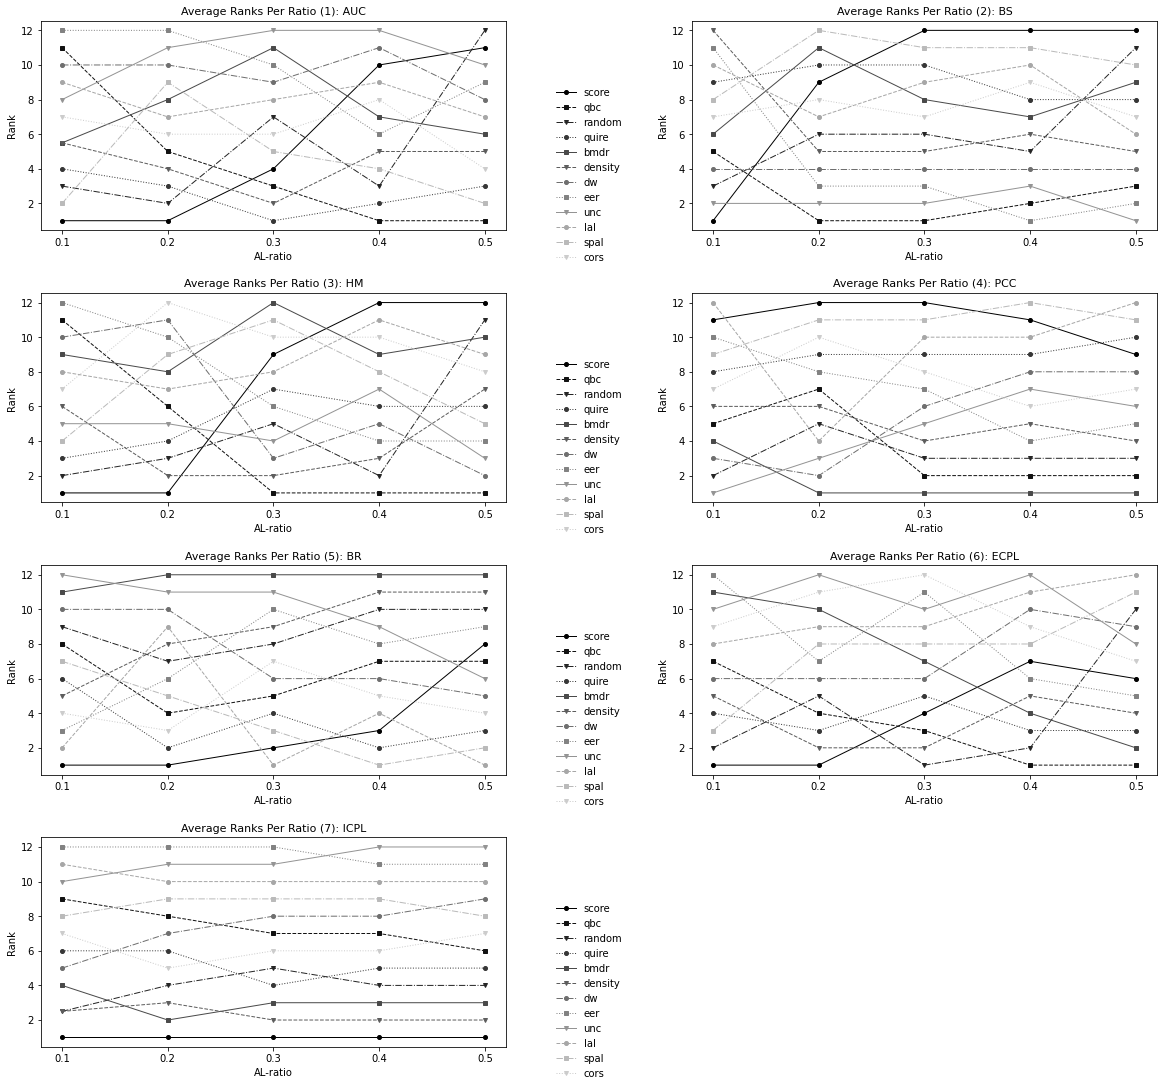

In [343]:
fig = plt.figure(figsize = (20, 30))
for i in enumerate(metric_tuples):
  m=i[1][0] #full metric name
  s=i[1][1] #short form
  p=i[1][2] #position of legend matchin shape of curves for respective metric

  data = ratio_ranks.loc[ratio_ranks.index.str.contains(f'{m}')]
  data.index = np.linspace(0.1,0.5,5)
  #print(data)
  plt.subplot(4, 2, i[0]+1)

  color=iter(cm.gray(np.linspace(0,0.8,len(data.columns))))
  lines = cycle(["-","--","-.",":"])
  markers = cycle(['o','s','v'])

  for c in data.columns:
    plt.plot(data.loc[:,c], 
             c=next(color), 
              ls=next(lines), 
              marker = next(markers),
              label = c,  linewidth = 1,
              markersize=4)
    plt.xlabel('AL-ratio', fontsize = 10)
    plt.title(f'Average Ranks Per Ratio ({i[0]+1}): {s}',fontsize = 11)
    plt.ylabel('Rank', fontsize = 10)
    plt.xticks(np.linspace(0.1,0.5,5))

    if i[0]%2==0:
      plt.legend(prop = {'size': 10}, fancybox=False, shadow=False, ncol=1, bbox_to_anchor=(1.08, -0.25, 0.2, 1.), borderaxespad=1.,frameon=False)
    
    fig.subplots_adjust(top=0.6,hspace=0.3,wspace=0.4)
    #fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(f'generational_plots/top6_ratio_ranks_wT.png', bbox_inches='tight', pad_inches=0.5)

In [ ]:
np.linspace(0.1,0.5,5)

array([0.1, 0.2, 0.3, 0.4, 0.5])

## mean ranks per RATIO: line plot (wF)

In [344]:
ratios_list = ["01","02","03","04","05"] #,0.2,0.3,0.4,0.5
# average over 100 rows (all datasets and generations)
model_order = [i.split('_', 1)[0] for i in test_results['overall'].index[0:7]] # get the base model names ordered by performance as in the main results table
columns=[i.split('_', 1)[0] for i in performance_sub.filter(regex='wF_r01|score').columns] # get the current order of models as in the data used for the plot
print('alphabetical order:',columns)
print('custom order:',model_order)
index_names=[]
ranks=[]

for s in metrics_list:

  for r in enumerate(ratios_list):
    index_names.append(f'{s}_{r[1]}')

    if s in ['roc_auc','h-measure','pcc','f1','average_precision','precision','recall','bad_ratio_rejects','balanced_accuracy','tn','tp']:
      ranks.append(performance_sub.filter(regex=f'wF_r{r[1]}|score').loc[performance_sub.index.str.contains(f'{s}')].rank(axis="columns", ascending = False).mean().rank().values)
    else:
      ranks.append(performance_sub.filter(regex=f'wF_r{r[1]}|score').loc[performance_sub.index.str.contains(f'{s}')].rank(axis="columns", ascending = True).mean().rank().values)
      
ratio_ranks = pd.DataFrame(ranks,columns=columns, index=index_names)
ratio_ranks = ratio_ranks.loc[:,model_order] #re-order the data to match the columns 

ratio_ranks

alphabetical order: ['bmdr', 'cors', 'density', 'dw', 'eer', 'lal', 'qbc', 'quire', 'random', 'score', 'spal', 'unc']
custom order: ['score', 'qbc', 'random', 'quire', 'bmdr', 'density', 'dw']


score   qbc  random  quire  bmdr  density    dw
roc_auc_01               9.0   5.0     4.0    2.0   3.0     11.0  10.0
roc_auc_02               9.0   1.0    12.0    2.0   3.0      7.0   6.0
roc_auc_03              11.0   7.0     3.0    1.0   5.0      4.0  10.0
roc_auc_04               8.0   4.0     5.0    1.0   3.0      6.0  12.0
roc_auc_05              11.0   1.0    12.0    3.0   6.0      5.0   8.0
brier_01                12.0   3.0     5.0    7.0  11.0      8.0   4.0
brier_02                12.0   2.0     9.0    6.0  10.0      7.0   4.0
brier_03                12.0   4.0     7.0    8.0   9.0      5.0   3.0
brier_04                12.0   3.0     7.0    8.0   6.0      5.0   4.0
brier_05                12.0   3.0    11.0    8.0   9.0      5.0   4.0
h-measure_01             5.0   6.0     3.0    1.0   4.0      9.0  11.0
h-measure_02             8.5   3.0    11.0    1.0   8.5      4.0   2.0
h-measure_03            12.0   6.0     2.0    7.0   9.0      3.0   8.0
h-measure_04            11.0   1.0     4.0    7.0   5.0      2.0   6.0
h-measure_05            12.0   1.0    11.0    6.0  10.0      7.0   2.0
pcc_01                  11.0   6.0     3.0   10.0   8.0      7.0   1.0
pcc_02                  10.0   3.0     5.0    8.0   4.0      6.0   1.0
pcc_03                   9.0   2.0     3.0   10.0   1.0      7.0   4.0
pcc_04                   9.0   2.0     5.0   11.0   1.0      3.0   7.0
pcc_05                   9.0   2.0     3.0   10.0   1.0      4.0   8.0
bad_ratio_test_01        3.0  10.0     5.0    2.0   9.0      6.0  12.0
bad_ratio_test_02        2.0  12.0     7.0    5.0  10.0      8.0  11.0
bad_ratio_test_03        4.0  11.0     5.0    3.0  12.0      6.0  10.0
bad_ratio_test_04        8.0  10.0     6.0    2.0  12.0      9.0   5.0
bad_ratio_test_05        8.0   7.0    10.0    3.0  12.0     11.0   5.0
external_cpl_01          5.0   7.0    10.0    3.0   6.0      8.0  12.0
external_cpl_02          4.0   5.0    11.0    1.0   3.0      9.0   6.0
external_cpl_03          4.0   9.0     1.0    7.0   5.0      3.0   2.0
external_cpl_04          5.0   1.0     6.0    3.0   4.0      7.0   8.0
external_cpl_05          6.0   1.0    10.0    3.0   2.0      4.0   9.0
total_internal_cpl_01    1.0   9.0     2.0    7.0   4.0      3.0   6.0
total_internal_cpl_02    1.0   6.0     5.0    4.0   2.0      3.0   8.0
total_internal_cpl_03    1.0   7.0     5.0    4.0   3.0      2.0   8.0
total_internal_cpl_04    1.0   7.0     4.0    5.0   2.0      3.0   9.0
total_internal_cpl_05    1.0   6.0     4.0    5.0   3.0      2.0   9.0

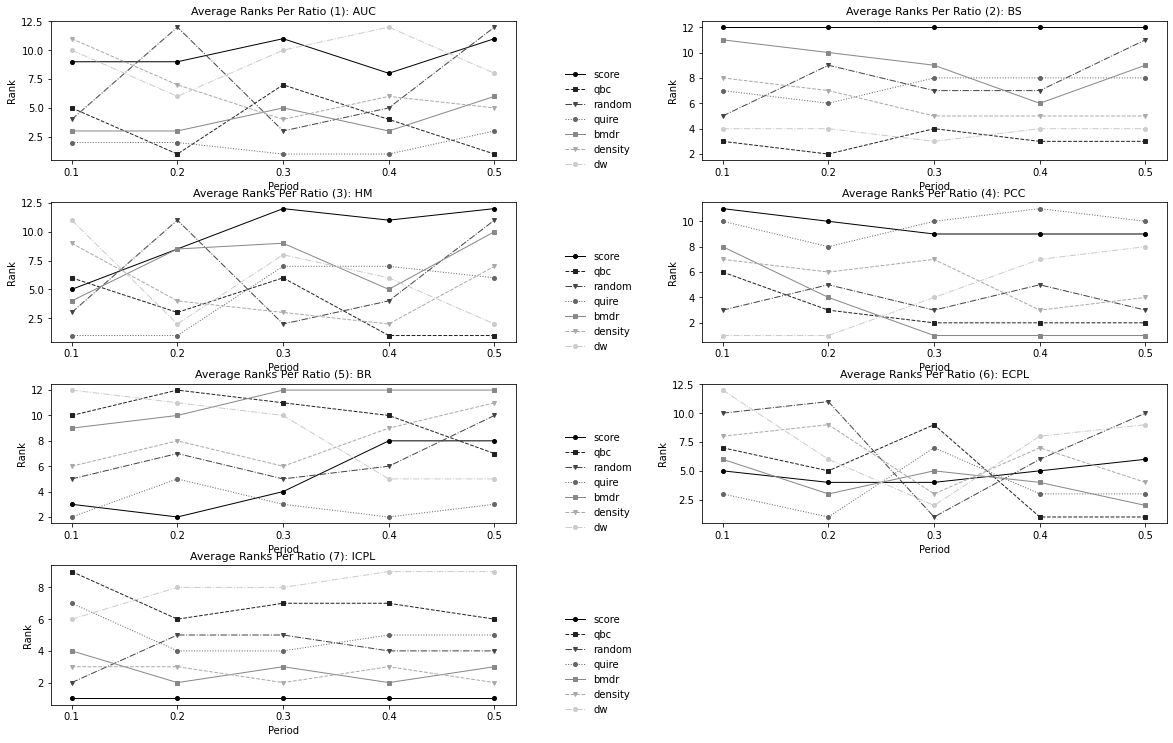

In [345]:
fig = plt.figure(figsize = (20, 20))
for i in enumerate(metric_tuples):
  m=i[1][0] #full metric name
  s=i[1][1] #short form
  p=i[1][2] #position of legend matchin shape of curves for respective metric

  data = ratio_ranks.loc[ratio_ranks.index.str.contains(f'{m}')]
  data.index = np.linspace(0.1,0.5,5)
  plt.subplot(4, 2, i[0]+1)

  color=iter(cm.gray(np.linspace(0,0.8,len(data.columns))))
  lines = cycle(["-","--","-.",":"])
  markers = cycle(['o','s','v'])

  for c in data.columns:
    plt.plot(data.loc[:,c], 
             c=next(color), 
              ls=next(lines), 
              marker = next(markers),
              label = c,  linewidth = 1,
              markersize=4)
    plt.xlabel('Period', fontsize = 10)
    plt.title(f'Average Ranks Per Ratio ({i[0]+1}): {s}',fontsize = 11)
    plt.ylabel('Rank', fontsize = 10)
    plt.xticks(np.linspace(0.1,0.5,5))

    if i[0]%2==0:
      plt.legend(prop = {'size': 10}, fancybox=False, shadow=False, ncol=1, bbox_to_anchor=(1.08, -0.25, 0.2, 1.), borderaxespad=1.,frameon=False)
    
    fig.subplots_adjust(top=0.6,hspace=0.3,wspace=0.4)
    #fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(f'generational_plots/top6_ratio_ranks_wF.png', bbox_inches='tight', pad_inches=0.5)

## mean ranks per WEIGHT: lollipop plot

In [ ]:
'''# IMPLEMENT THIS BASED ON THE INITIAL RANKS (1 to 120)
# OR DO IT WITH THE INITIAL SCORES!?
# first build mean values for all versions of a model (ratios!) in each domain (metric * dataset)
# then build ranks for each of these condensed sub-sections
# then aggregate the ranks (mean)
# then re-rank to project to 1-12 scale

weights_list = ['wT', 'wF']

model_order = [i.split('_', 1)[0] for i in test_results['overall'].index[0:12]] # get the base model names ordered by performance as in the main results table
columns=[i.split('_', 1)[0] for i in performance_sub_ranks.filter(regex='wF_r01|score').columns] # get the current order of models as in the data used for the plot
print('alphabetical order:',columns)
print('custom order:',model_order)
index_names=[]
ranks=[]

for s in metrics_list:
  for d in dataset_list:
    for r in weights_list:
      index_names.append(f'{s}_{r}')
      ranks.append(performance_sub.filter(regex=f'{r}|score').loc[performance_sub.index.str.contains(f'{s}')].mean().rank().values)
      # wrong shape, because I do not filter (or merge) ratios, so I get 11 models * 5 ratios + 1(score) columns

    #print(index_names)
    #print('ranks',ranks)
print(np.shape(ranks))
print(columns)
print(index_names)
weight_ranks = pd.DataFrame(ranks, index=index_names)
#weight_ranks = weight_ranks.loc[:,model_order] #re-order the data to match the columns 

weight_ranks'''

In [54]:
#performance_sub.filter(regex=f'random').loc[performance_sub.index.str.contains(f'bene2_roc_auc')]

random_wF_r01 random_wF_r02 random_wF_r03 random_wF_r04  \
bene2_roc_auc_g1       0.767747      0.765351      0.765912      0.768434   
bene2_roc_auc_g2       0.771066      0.771131      0.768145      0.772394   
bene2_roc_auc_g3       0.775039      0.775088      0.772686      0.775547   
bene2_roc_auc_g4       0.777255       0.77585      0.776291      0.776988   
bene2_roc_auc_g5       0.780345      0.778946      0.779984      0.780194   
bene2_roc_auc_g6       0.780668      0.779469      0.780817      0.780252   
bene2_roc_auc_g7       0.781443      0.779959       0.78126      0.780534   
bene2_roc_auc_g8       0.781986      0.781748      0.781484      0.781421   
bene2_roc_auc_g9        0.78246      0.781898       0.78203      0.781008   
bene2_roc_auc_g10      0.782534      0.781858      0.781587      0.780649   

                  random_wF_r05 random_wT_r01 random_wT_r02 random_wT_r03  \
bene2_roc_auc_g1       0.766735       0.75766      0.762809      0.765291   
bene2_roc_auc_g2       0.769033      0.759129      0.769283      0.767009   
bene2_roc_auc_g3       0.772843      0.759609      0.770805        0.7733   
bene2_roc_auc_g4       0.775395      0.762208      0.774743      0.777898   
bene2_roc_auc_g5       0.777919      0.771234      0.777052       0.78197   
bene2_roc_auc_g6       0.778877      0.772935       0.77975       0.78284   
bene2_roc_auc_g7       0.780077      0.773732      0.780047      0.783425   
bene2_roc_auc_g8       0.781296      0.776615      0.780975      0.783866   
bene2_roc_auc_g9       0.781188      0.777953      0.781298      0.783833   
bene2_roc_auc_g10      0.781039      0.777536      0.782156      0.783348   

                  random_wT_r04 random_wT_r05  
bene2_roc_auc_g1       0.770053      0.766735  
bene2_roc_auc_g2       0.774078      0.769033  
bene2_roc_auc_g3       0.776794      0.772843  
bene2_roc_auc_g4       0.776804      0.775395  
bene2_roc_auc_g5       0.778562      0.777919  
bene2_roc_auc_g6       0.779538      0.778877  
bene2_roc_auc_g7       0.779887      0.780077  
bene2_roc_auc_g8       0.780709      0.781296  
bene2_roc_auc_g9       0.780463      0.781188  
bene2_roc_auc_g10      0.781233      0.781039

In [276]:
# first build mean values for all versions of a model (ratios!) across all generations in each domain (metric x dataset)
# then build ranks for each of these condensed sub-sections
# then aggregate the ranks (mean)
# then re-rank to project to 1-12 scale

dict_w = {'wF': [], 'wT': []}
for w in ['wT', 'wF']:
  weight_ranks = []
  
  for s in metrics_list:
    metric_values = []

    for d in dataset_list:
      row_values = []

      for m in model_list:
        if m != 'score':
          row_values.append(performance_sub.filter(regex=f'{m}_{w}').loc[performance_sub.index.str.contains(f'{d}_{s}')].mean().mean()) #mean scores over 10 generations and 5 ratios
        else:
          row_values.append(performance_sub[f'{m}'].loc[performance_sub.index.str.contains(f'{d}_{s}')].mean()) #mean over 10 generations, no ratios with score model
      #print(d,s, 'row', row_values)
      metric_values.append(row_values)
      
    if s in ['roc_auc','h-measure','pcc','f1','average_precision','precision','recall','bad_ratio_rejects','balanced_accuracy','tn','tp']:
      metric_values = np.array(metric_values) * -1 #inverse scores for correct ranking (default ranking is descending)

    #print(s,np.shape(metric_values), metric_values)
    #print(metric_values)

    for i in range(len(metric_values)):
      metric_values[i] = scipy.stats.rankdata(metric_values[i])
    
    #print('RANKED',s,np.shape(metric_values), metric_values) 
    metric_avg_ranks = [np.mean([case[i] for case in metric_values]) for i in range(len(model_list))]
    weight_ranks.append(metric_avg_ranks)

    #print(pd.DataFrame(metric_values, columns = model_list).rank(axis=1))
  
  print(f"for each of {np.shape(weight_ranks)[0]} metrics, there are {np.shape(weight_ranks)[1]} average values, one for each model, across datasets")
  print(weight_ranks)
  #[[case[i][j] for case in weight_ranks]] for i in range(len(model_list)) for j in range(len(metrics_list))
  #
  #rankings_avg = [np.mean([case[j] for case in weight_ranks]) for j in range(len(metrics_list))] #data is an array that includes 10 arrays (one for each dataset) of 12 values (one for each model).
  
  dict_w[w]=pd.DataFrame(weight_ranks, columns=model_list, index=metrics_list)

for each of 7 metrics, there are 12 average values, one for each model, across datasets
[[4.7, 6.2, 7.3, 6.1, 7.8, 6.9, 6.2, 7.1, 7.2, 5.7, 6.6, 6.2], [7.6, 6.7, 3.6, 4.4, 5.9, 7.2, 7.0, 5.6, 6.8, 7.1, 7.7, 8.4], [5.2, 6.0, 5.6, 6.3, 6.1, 7.8, 5.7, 7.1, 7.4, 6.6, 7.0, 7.2], [8.2, 5.3, 5.3, 5.6, 6.6, 6.6, 6.5, 6.6, 8.0, 6.8, 4.4, 8.1], [4.2, 6.7, 8.8, 6.1, 7.1, 5.6, 7.2, 6.0, 5.1, 6.0, 9.6, 5.6], [4.2, 5.3, 8.4, 5.6, 8.5, 6.9, 5.1, 6.7, 7.5, 4.9, 7.7, 7.2], [1.3, 5.8, 9.6, 6.9, 7.5, 6.6, 4.8, 9.1, 8.4, 5.6, 5.2, 7.2]]
for each of 7 metrics, there are 12 average values, one for each model, across datasets
[[6.5, 7.2, 6.5, 5.5, 7.0, 7.9, 7.2, 7.4, 7.2, 4.8, 6.0, 4.8], [10.2, 7.6, 3.6, 5.5, 5.5, 7.3, 6.0, 4.1, 6.5, 6.4, 7.5, 7.8], [7.4, 6.5, 5.4, 5.7, 5.6, 7.8, 6.1, 6.4, 7.6, 6.0, 6.6, 6.9], [7.1, 5.9, 5.6, 6.0, 6.1, 6.1, 6.8, 6.0, 8.1, 7.1, 4.9, 8.3], [6.5, 6.9, 6.0, 6.6, 7.2, 7.0, 6.9, 6.4, 4.6, 5.8, 8.7, 5.4], [5.4, 6.6, 6.9, 6.1, 7.4, 8.0, 6.9, 6.4, 7.3, 5.0, 5.5, 6.5], [1.3, 5.5, 9.8,

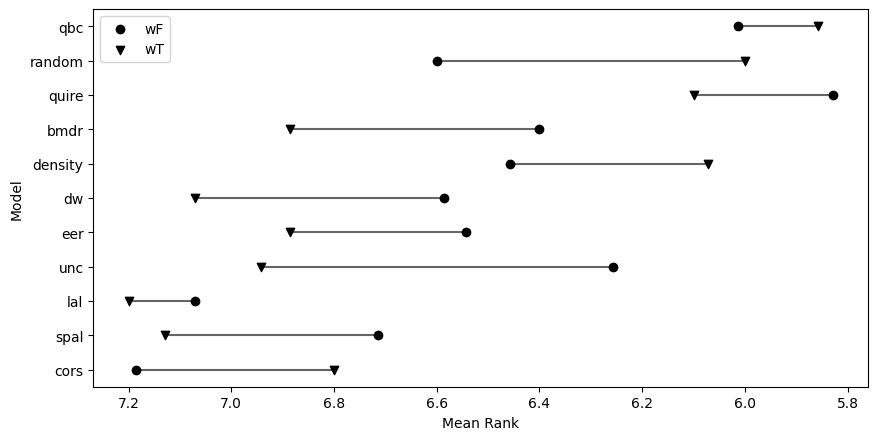

In [291]:
# PLOT

fig, ax = plt.subplots(figsize=[10,5], dpi=100)
value1=dict_w['wF'].iloc[:,1:].mean()
value2=dict_w['wT'].iloc[:,1:].mean()
df = pd.DataFrame({'group':[i for i in model_list if i != 'score'], 'wF':value1 , 'wT':value2 })
#print(df)
# Reorder it following the values of the first value:
model_order = [i.split('_', 1)[0] for i in test_results['overall'].index[1:12]]
#print(model_order)
ordered_df = df.loc[model_order,:]
my_range=range(1,len(df.index)+1)

#fig.set_size_inches(10, 5, forward=True)

ax.hlines(y=my_range, xmin=ordered_df['wF'], xmax=ordered_df['wT'], color='black', alpha=0.6)
ax.scatter(ordered_df['wF'], my_range, color='black', label='wF', marker='o')
ax.scatter(ordered_df['wT'], my_range, color='black', label='wT', marker='v')

#ax.set_xlim(7.5, 5.5)  # decreasing time
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('Mean Rank',fontsize = 10)
ax.set_ylabel('Model',fontsize = 10)
#ax.set_title('Average Ranks per weight option')

ax.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['group'])

plt.savefig(f'generational_plots/average_ranks_weight-options.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

## MEH Ranks for each metric, across datasets, over 10 rounds

In [ ]:
performance_sub_ranks = performance_sub.rank(ascending=False, axis="columns")
performance_sub_ranks.loc[~performance_sub_ranks.index.str.contains('roc_auc|h-measure|pcc|f1|average_precision|precision|recall|bad_ratio_rejects')] = performance_sub.loc[~performance_sub.index.str.contains('roc_auc|h-measure|pcc|f1|average_precision|precision|recall|bad_ratio_rejects')].rank(ascending=True, axis="columns")


In [ ]:
col = test_results['overall'].index[0:12]
for m,s,p in metric_tuples:
  fig = plt.figure(figsize = (20, 30))
  
  for i in enumerate(dataset_list):
    data = performance_sub.loc[performance_sub.index.str.contains(f'{i[1]}_{m}')].loc[:,best_performers['overall']]
    data_ranks = data.rank(ascending=False, axis="columns")
    data_ranks.loc[~data_ranks.index.str.contains('roc_auc|h-measure|pcc|f1|average_precision|precision|recall|bad_ratio_rejects')] = data.loc[~data.index.str.contains('roc_auc|h-measure|pcc|f1|average_precision|precision|recall|bad_ratio_rejects')].rank(ascending=True, axis="columns")

    #data.index = range(1,11)
    
    data_ranks.index = range(1,11)
    data_ranks = data_ranks.loc[:,col]

    plt.subplot(5, 2, i[0]+1)

    #color=iter(cm.rainbow(np.linspace(0,1,len(data.columns))))
    color=iter(cm.gray(np.linspace(0,0.8,len(data_ranks.columns))))
    lines = cycle(["-","--","-.",":"])
    #lines = cycle(["-",":"])
    markers = cycle(['o','s','v'])
    #color=cycle(['k','c', 'y','m'])
    #color=cycle(['r', 'g', 'b', 'k'])
    #color=cycle(['0.0', '0.2', '0.6', '0.8'])

    for c in data_ranks.columns:
      #l=next(lines)
      #d = next(markers)
      plt.plot(data_ranks.loc[:,c],
               c=next(color), 
               ls=next(lines), 
               marker = next(markers),
               label = c,  linewidth = 1,
               markersize=4)
      plt.xlabel('Period', fontsize = 10)
      plt.title(i[1].replace('_nobins',''),fontsize = 11)
      plt.ylabel(s, fontsize = 10)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
      #plt.legend(prop = {'size': 8}, loc=p, fancybox=True, shadow=False, ncol=3) #loc='upper center', bbox_to_anchor=(0.7, 0.4),

      if i[0]%2==0:
        plt.legend(prop = {'size': 10}, fancybox=False, shadow=False, ncol=1, bbox_to_anchor=(1.08, -0.1, 0.2, 1.), borderaxespad=0.,frameon=False)
      
      fig.subplots_adjust(hspace=0.3,wspace=0.4)
      #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
  plt.savefig(f'generational_plots/{s}_ranks.png', bbox_inches='tight', pad_inches=10.5)